In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import linregress
import warnings

warnings.filterwarnings('ignore')

In [58]:
dataset1 = pd.read_csv('logs/db12-datalog_20250702_105006.csv')

# Print the first 5 rows of the dataset
print(dataset1.head())

# Print the last 5 rows of the dataset
print(dataset1.tail())

                 Timestamp  Accel_X_g  Accel_Y_g  Accel_Z_g  GPS_Fix  \
0  2025-07-02 10:54:03.957      268.0       72.0     1084.0        1   
1  2025-07-02 10:54:04.936     -220.0     -164.0      884.0        1   
2  2025-07-02 10:54:05.921      264.0       52.0     1000.0        1   
3  2025-07-02 10:54:06.909       76.0      -12.0      760.0        1   
4  2025-07-02 10:54:07.883       84.0      168.0      992.0        1   

   Speed_kmh  
0       84.0  
1       84.0  
2       84.0  
3       84.0  
4       84.0  
                    Timestamp  Accel_X_g  Accel_Y_g  Accel_Z_g  GPS_Fix  \
1374  2025-07-02 11:16:33.530       32.0      -72.0     1000.0        1   
1375  2025-07-02 11:16:34.511      108.0       60.0     1044.0        1   
1376  2025-07-02 11:16:35.494      216.0       64.0     1036.0        1   
1377  2025-07-02 11:16:36.503      184.0      -72.0     1076.0        1   
1378  2025-07-02 11:16:37.472      288.0      -52.0     1052.0        1   

      Speed_kmh  
1374    

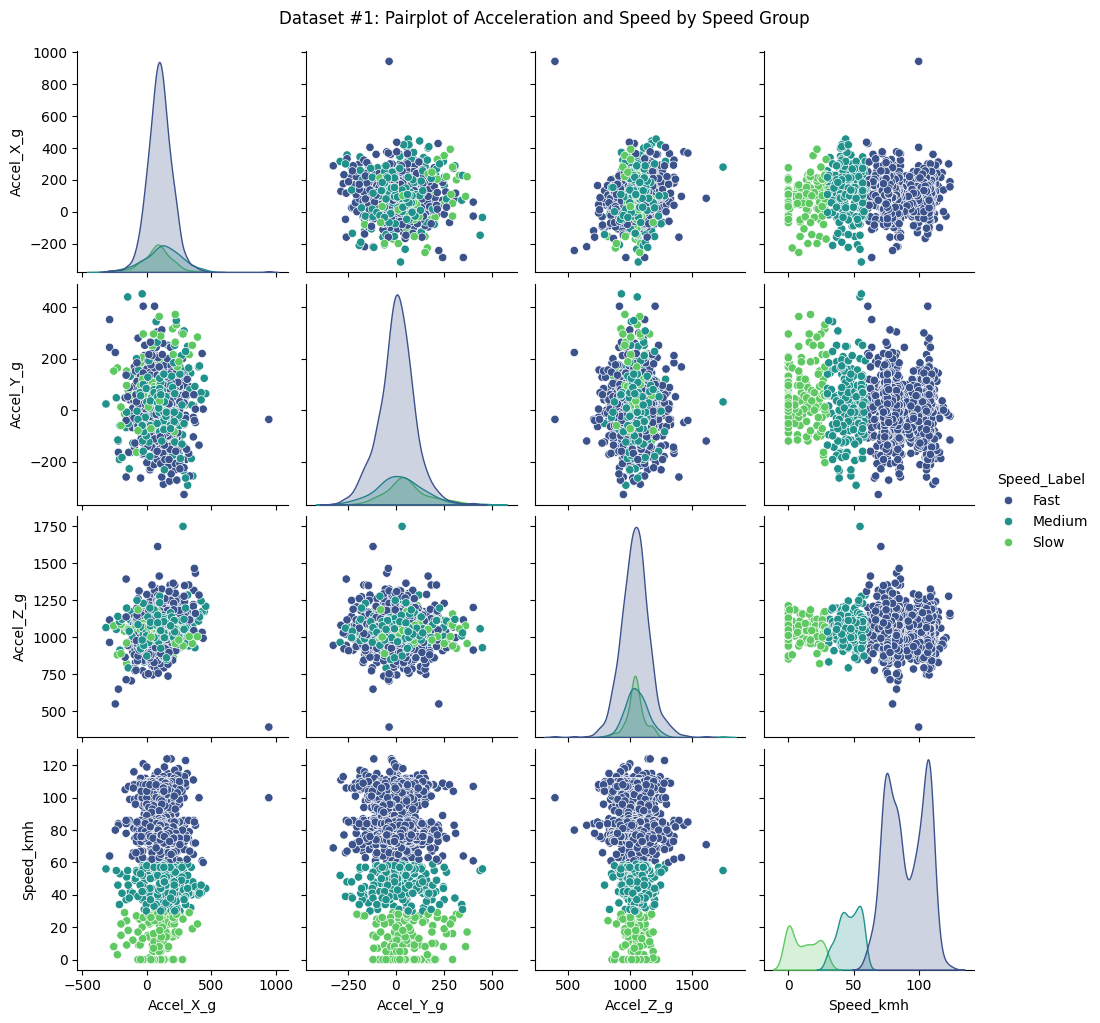

In [59]:
def label_speed(speed):
    if speed < 30:
        return 'Slow'
    elif speed < 60:
        return 'Medium'
    else:
        return 'Fast'

dataset1['Speed_Label'] = dataset1['Speed_kmh'].apply(label_speed)

# Then plot using speed label as hue
sns.pairplot(dataset1, vars=['Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'Speed_kmh'], hue='Speed_Label', palette='viridis')
plt.suptitle('Dataset #1: Pairplot of Acceleration and Speed by Speed Group', y=1.02)
plt.show()

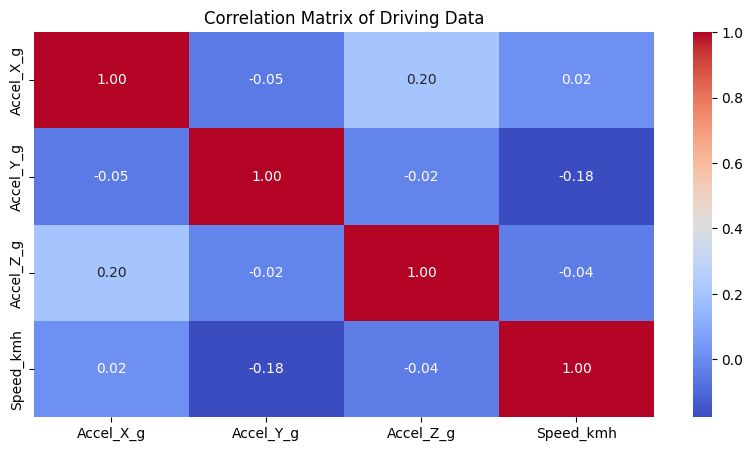

In [60]:
# Select numeric columns to include in the correlation matrix
columns_to_use = ['Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'Speed_kmh']

plt.figure(figsize=(10, 5))
sns.heatmap(
    dataset1[columns_to_use].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('Correlation Matrix of Driving Data')
plt.show()

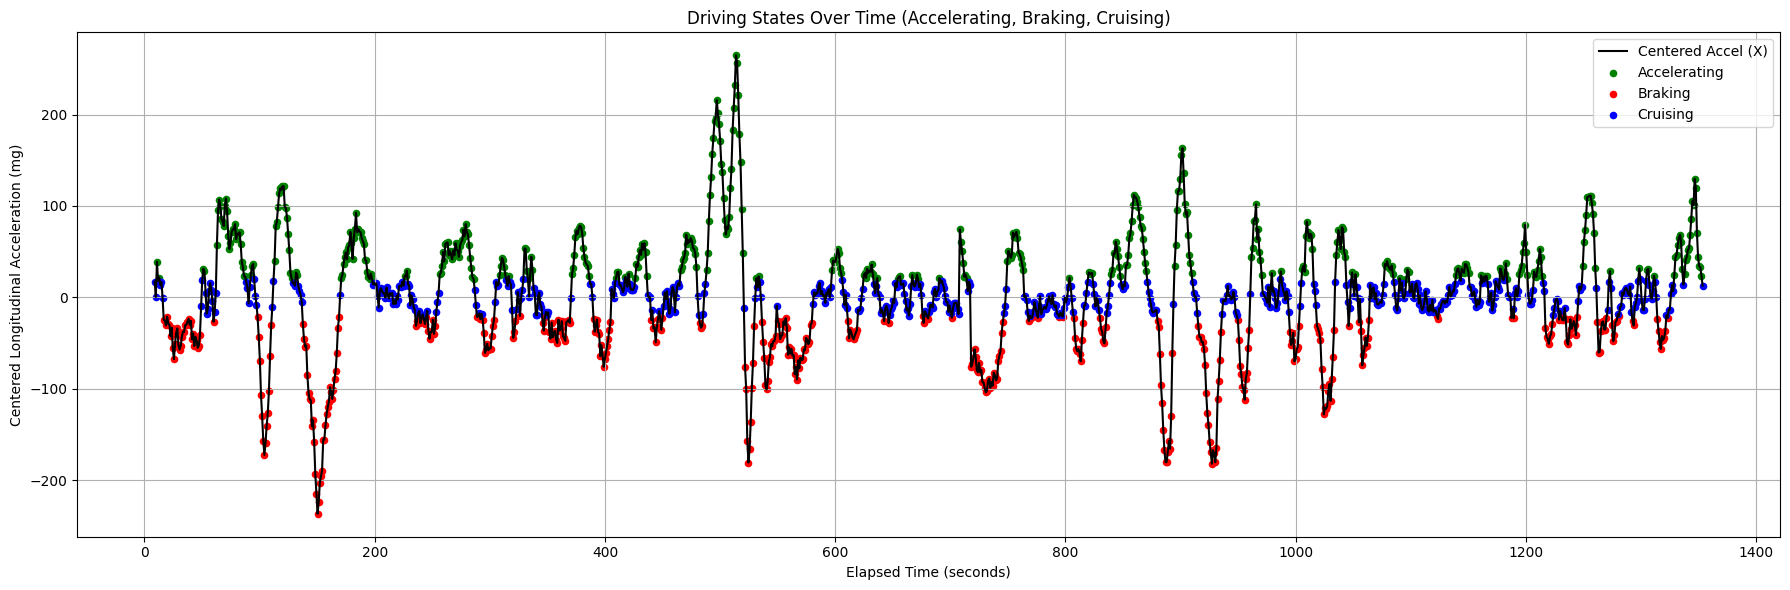

Driving Event Classification Summary
▶ Acceleration Threshold : +20 mg
▶ Braking Threshold      : -20 mg
----------------------------------------
Event Type           Count    Percent
----------------------------------------
Cruising               536      38.9%
Accelerating           429      31.1%
Braking                414      30.0%



In [61]:
# Step 1: Smooth the longitudinal acceleration
dataset1['X_filt'] = dataset1['Accel_X_g'].rolling(window=10).mean()

# Step 2: Center the filtered acceleration around 0
dataset1['X_centered'] = dataset1['X_filt'] - dataset1['X_filt'].mean()

# Step 3: Compute elapsed time in seconds from the start
# Ensure Timestamp is datetime
dataset1['Timestamp'] = pd.to_datetime(dataset1['Timestamp'])

# Calculate elapsed time in seconds
dataset1['Elapsed_s'] = (dataset1['Timestamp'] - dataset1['Timestamp'].iloc[0]).dt.total_seconds()


# Step 4: Define thresholds (in mg) for classification
ACCEL_THRESHOLD = 20   # ~0.2 m/s²
BRAKE_THRESHOLD = -20  # ~-0.2 m/s²

# Step 5: Classify driving states
dataset1['Event'] = 'Cruising'
dataset1.loc[dataset1['X_centered'] > ACCEL_THRESHOLD, 'Event'] = 'Accelerating'
dataset1.loc[dataset1['X_centered'] < BRAKE_THRESHOLD, 'Event'] = 'Braking'

# Step 6: Define event colors
event_colors = {
    'Accelerating': 'green',
    'Braking': 'red',
    'Cruising': 'blue'
}

# Step 7: Plot
plt.figure(figsize=(18, 6))

# Plot centered acceleration line
plt.plot(dataset1['Elapsed_s'], dataset1['X_centered'], label='Centered Accel (X)', color='black', linewidth=1.5)

# Scatter points by event
for event_type, color in event_colors.items():
    subset = dataset1[dataset1['Event'] == event_type]
    plt.scatter(subset['Elapsed_s'], subset['X_centered'], label=event_type, color=color, s=20)

# Formatting
plt.title('Driving States Over Time (Accelerating, Braking, Cruising)')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Centered Longitudinal Acceleration (mg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Print driving event counts
event_counts = dataset1['Event'].value_counts()
event_percents = dataset1['Event'].value_counts(normalize=True) * 100

#----------PRINT EVENT COUNTS AND PERCENTAGES-------
# print("Driving Event Counts:")
# event_counts = dataset1['Event'].value_counts()
# print(event_counts)

#-----------SUMMARY OF DRIVING EVENTS-----------
# Step 8: Print driving event counts and percentages
print("Driving Event Classification Summary")
print("========================================")
print(f"▶ Acceleration Threshold : +{ACCEL_THRESHOLD} mg")
print(f"▶ Braking Threshold      : {BRAKE_THRESHOLD} mg")
print("----------------------------------------")
print(f"{'Event Type':<15} {'Count':>10} {'Percent':>10}")
print("-" * 40)

for event in event_counts.index:
    count = event_counts[event]
    percent = event_percents[event]
    print(f"{event:<15} {count:>10} {percent:>9.1f}%")

print("========================================\n")



Driving Event Classification Summary
▶ Acceleration Threshold : +20 mg
▶ Braking Threshold      : -20 mg
----------------------------------------
Event Type           Count    Percent
----------------------------------------
Cruising               536      38.9%
Accelerating           429      31.1%
Braking                414      30.0%



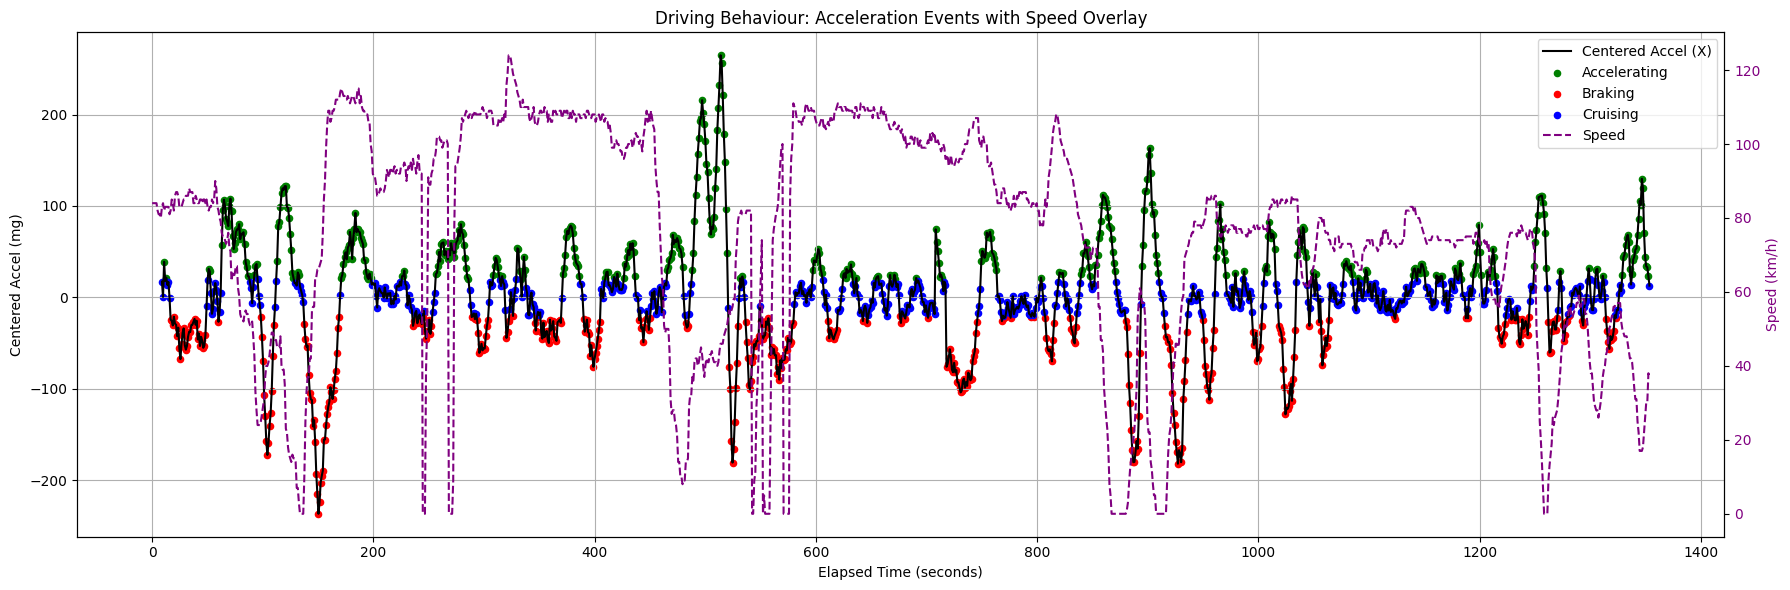

In [62]:
# -------------------------------------------------------
# Step 1: Define function to classify driving events
# -------------------------------------------------------
def classify_driving_events(df, accel_column='X_centered', accel_thresh=50, brake_thresh=-50):
    """
    Classify driving states (Accelerating, Braking, Cruising) based on centered acceleration.
    
    Parameters:
        df (pd.DataFrame): DataFrame with an acceleration column.
        accel_column (str): Name of the acceleration column to use.
        accel_thresh (float): Threshold (mg) above which is Accelerating.
        brake_thresh (float): Threshold (mg) below which is Braking.
        
    Returns:
        pd.Series: Series with labels 'Accelerating', 'Braking', or 'Cruising'
    """
    event = pd.Series(['Cruising'] * len(df), index=df.index)
    event[df[accel_column] > accel_thresh] = 'Accelerating'
    event[df[accel_column] < brake_thresh] = 'Braking'
    return event


# -------------------------------------------------------
# Step 2: Set thresholds and apply classification
# -------------------------------------------------------
ACCEL_THRESHOLD = 20  # mg
BRAKE_THRESHOLD = -20  # mg

dataset1['Event'] = classify_driving_events(
    dataset1,
    accel_column='X_centered',
    accel_thresh=ACCEL_THRESHOLD,
    brake_thresh=BRAKE_THRESHOLD
)

# -------------------------------------------------------
# Step 3: Print event summary
# -------------------------------------------------------
event_counts = dataset1['Event'].value_counts()
event_percents = dataset1['Event'].value_counts(normalize=True) * 100

print("Driving Event Classification Summary")
print("========================================")
print(f"▶ Acceleration Threshold : +{ACCEL_THRESHOLD} mg")
print(f"▶ Braking Threshold      : {BRAKE_THRESHOLD} mg")
print("----------------------------------------")
print(f"{'Event Type':<15} {'Count':>10} {'Percent':>10}")
print("-" * 40)
for event in event_counts.index:
    print(f"{event:<15} {event_counts[event]:>10} {event_percents[event]:>9.1f}%")
print("========================================\n")

# -------------------------------------------------------
# Step 4: Plot acceleration events with speed overlay
# -------------------------------------------------------
event_colors = {
    'Accelerating': 'green',
    'Braking': 'red',
    'Cruising': 'blue'
}

fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot centered acceleration on primary y-axis
ax1.set_xlabel('Elapsed Time (seconds)')
ax1.set_ylabel('Centered Accel (mg)', color='black')
ax1.plot(dataset1['Elapsed_s'], dataset1['X_centered'], color='black', label='Centered Accel (X)', linewidth=1.5)

# Add scatter points by event
for event_type, color in event_colors.items():
    subset = dataset1[dataset1['Event'] == event_type]
    ax1.scatter(subset['Elapsed_s'], subset['X_centered'], label=event_type, color=color, s=20)

ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Plot speed on secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Speed (km/h)', color='purple')
ax2.plot(dataset1['Elapsed_s'], dataset1['Speed_kmh'], color='purple', linestyle='--', label='Speed', linewidth=1.5)
ax2.tick_params(axis='y', labelcolor='purple')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Final formatting
plt.title('Driving Behaviour: Acceleration Events with Speed Overlay')
plt.tight_layout()
plt.show()

In [63]:
def find_dynamic_stable_speed_segments(df, speed_col='Speed_kmh', time_col='Elapsed_s',
                                       rolling_window=5, std_threshold=2.0, min_duration=30):
    """
    Dynamically detect continuous stable-speed segments.
    
    Parameters:
        df (pd.DataFrame): Must contain speed and time columns.
        speed_col (str): Column name for speed (e.g. 'Speed_kmh').
        time_col (str): Column for time in seconds (e.g. 'Elapsed_s').
        rolling_window (int): Window size in seconds for rolling std dev.
        std_threshold (float): Max allowed std dev to call speed 'stable'.
        min_duration (int): Minimum duration (in seconds) for a segment to be valid.
        
    Returns:
        List of (start_time, end_time, segment_df)
    """
    df = df.copy()
    
    # Rolling std dev
    df['Speed_Std'] = df[speed_col].rolling(window=rolling_window, min_periods=1).std()

    # Mark where it's stable
    df['Stable'] = df['Speed_Std'] < std_threshold

    segments = []
    in_segment = False
    segment_start = None

    for i in range(len(df)):
        if df['Stable'].iloc[i] and not in_segment:
            in_segment = True
            segment_start = df[time_col].iloc[i]

        elif not df['Stable'].iloc[i] and in_segment:
            segment_end = df[time_col].iloc[i]
            duration = segment_end - segment_start

            if duration >= min_duration:
                seg_df = df[(df[time_col] >= segment_start) & (df[time_col] < segment_end)]
                segments.append((segment_start, segment_end, seg_df))
            
            in_segment = False

    # Handle case where end of data is still stable
    if in_segment:
        segment_end = df[time_col].iloc[-1]
        duration = segment_end - segment_start
        if duration >= min_duration:
            seg_df = df[(df[time_col] >= segment_start) & (df[time_col] <= segment_end)]
            segments.append((segment_start, segment_end, seg_df))

    return segments

segments = find_dynamic_stable_speed_segments(
    dataset1,
    rolling_window=5,       # seconds
    std_threshold=3.0,      # tighter = more selective
    min_duration=30         # seconds
)

print(f"Stable segments found: {len(segments)}")
for i, (start, end, _) in enumerate(segments):
    print(f"Segment {i+1}: {start:.1f}s to {end:.1f}s ({end - start:.1f}s)")

Stable segments found: 10
Segment 1: 1.0s to 60.0s (59.0s)
Segment 2: 162.1s to 197.5s (35.4s)
Segment 3: 203.4s to 244.6s (41.2s)
Segment 4: 283.0s to 320.3s (37.3s)
Segment 5: 325.2s to 446.0s (120.8s)
Segment 6: 583.6s to 748.5s (165.0s)
Segment 7: 758.3s to 807.4s (49.1s)
Segment 8: 966.5s to 1010.7s (44.2s)
Segment 9: 1056.9s to 1133.5s (76.6s)
Segment 10: 1136.4s to 1209.1s (72.7s)


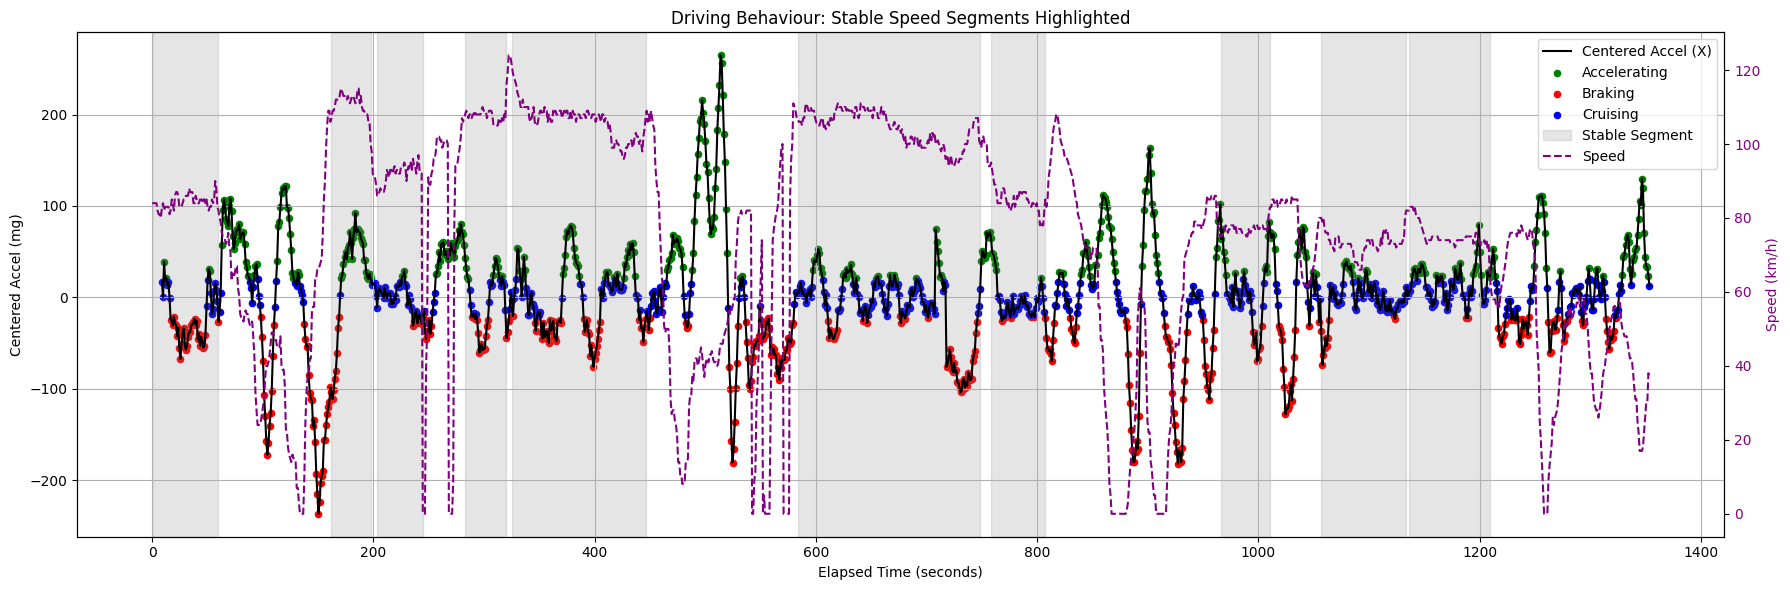

In [64]:
def plot_stable_segments(df, stable_segments, accel_col='X_centered', speed_col='Speed_kmh',
                         time_col='Elapsed_s', event_col='Event'):
    """
    Plot acceleration and speed with highlighted stable-speed segments.
    
    Parameters:
        df (DataFrame): Full dataset with acceleration, speed, event, and time columns.
        stable_segments (list): Output from find_dynamic_stable_speed_segments().
        accel_col (str): Name of centered acceleration column.
        speed_col (str): Name of speed column.
        time_col (str): Elapsed time column (in seconds).
        event_col (str): Event classification column.
    """
    fig, ax1 = plt.subplots(figsize=(18, 6))

    # Plot centered acceleration
    ax1.set_xlabel('Elapsed Time (seconds)')
    ax1.set_ylabel('Centered Accel (mg)', color='black')
    ax1.plot(df[time_col], df[accel_col], color='black', label='Centered Accel (X)', linewidth=1.5)

    # Color scatter points by event
    event_colors = {'Accelerating': 'green', 'Braking': 'red', 'Cruising': 'blue'}
    for event, color in event_colors.items():
        mask = df[event_col] == event
        ax1.scatter(df[time_col][mask], df[accel_col][mask], color=color, s=20, label=event)

    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True)

    # Add shaded stable segments
    for start, end, _ in stable_segments:
        ax1.axvspan(start, end, color='gray', alpha=0.2, label='Stable Segment')

    # Plot speed on second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Speed (km/h)', color='purple')
    ax2.plot(df[time_col], df[speed_col], linestyle='--', color='purple', label='Speed', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor='purple')

    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    seen = set()
    final_labels = []
    final_handles = []
    for h, l in zip(handles1 + handles2, labels1 + labels2):
        if l not in seen:
            seen.add(l)
            final_labels.append(l)
            final_handles.append(h)

    ax1.legend(final_handles, final_labels, loc='upper right')

    plt.title('Driving Behaviour: Stable Speed Segments Highlighted')
    plt.tight_layout()
    plt.show()

plot_stable_segments(dataset1, segments)

In [65]:
def statistics_segment(segment_df):
    """
    Compute combined speed and acceleration statistics for a segment.
    """
    duration = segment_df['Elapsed_s'].max() - segment_df['Elapsed_s'].min()
    
    # Speed stats
    mean_speed = segment_df['Speed_kmh'].mean()
    std_speed = segment_df['Speed_kmh'].std()
    min_speed = segment_df['Speed_kmh'].min()
    max_speed = segment_df['Speed_kmh'].max()

    # Acceleration stats
    mean_accel = segment_df['X_centered'].mean()
    std_accel = segment_df['X_centered'].std()
    min_accel = segment_df['X_centered'].min()
    max_accel = segment_df['X_centered'].max()

    # Driving event counts
    event_counts = segment_df['Event'].value_counts()
    accel_count = event_counts.get('Accelerating', 0)
    brake_count = event_counts.get('Braking', 0)
    cruise_count = event_counts.get('Cruising', 0)

    return {
        'Start Time (s)': segment_df['Elapsed_s'].min(),
        'End Time (s)': segment_df['Elapsed_s'].max(),
        'Duration (s)': duration,
        'Mean Speed (km/h)': mean_speed,
        'Std Speed (km/h)': std_speed,
        'Min Speed (km/h)': min_speed,
        'Max Speed (km/h)': max_speed,
        'Mean Accel (mg)': mean_accel,
        'Std Accel (mg)': std_accel,
        'Min Accel (mg)': min_accel,
        'Max Accel (mg)': max_accel,
        'Accelerating Count': accel_count,
        'Braking Count': brake_count,
        'Cruising Count': cruise_count
    }

def summarise_all_segments(segments):
    """
    Generate full statistics (speed + acceleration + event counts) for all segments.
    """
    summary_list = []

    for i, (_, _, seg_df) in enumerate(segments):
        stats = statistics_segment(seg_df)
        stats['Segment'] = f"Segment {i+1}"
        summary_list.append(stats)
    
    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_list)
    
    # Optional: Rearranged column order
    column_order = [
        'Segment', 'Start Time (s)', 'End Time (s)', 'Duration (s)',
        'Mean Speed (km/h)', 'Std Speed (km/h)', 'Min Speed (km/h)', 'Max Speed (km/h)',
        'Mean Accel (mg)', 'Std Accel (mg)', 'Min Accel (mg)', 'Max Accel (mg)',
        'Accelerating Count', 'Braking Count', 'Cruising Count'
    ]
    
    return summary_df[column_order]

summary_df = summarise_all_segments(segments)
display(summary_df)

Segment  Start Time (s)  End Time (s)  Duration (s)  Mean Speed (km/h)  \
0   Segment 1           0.979        58.988        58.009          84.283333   
1   Segment 2         162.126       196.507        34.381         111.194444   
2   Segment 3         203.410       243.655        40.245          91.976190   
3   Segment 4         282.961       319.324        36.363         107.578947   
4   Segment 5         325.207       445.063       119.856         106.300813   
5   Segment 6         583.569       747.541       163.972         104.380952   
6   Segment 7         758.339       806.450        48.111          84.860000   
7   Segment 8         966.505      1009.708        43.203          76.977778   
8   Segment 9        1056.858      1132.514        75.656          73.089744   
9  Segment 10        1136.426      1208.139        71.713          75.243243   

   Std Speed (km/h)  Min Speed (km/h)  Max Speed (km/h)  Mean Accel (mg)  \
0          1.923024              80.0              90.0       -21.368961   
1          2.447383             106.0             115.0        21.857534   
2          2.806683              86.0              97.0        -1.105958   
3          1.368202             105.0             110.0        -4.616735   
4          4.639345              96.0             121.0         0.908212   
5          4.632364              94.0             111.0       -10.596434   
6          3.362518              78.0              95.0        -2.681577   
7          1.196375              75.0              82.0         3.290868   
8          2.838446              66.0              80.0        -2.030500   
9          2.851632              72.0              83.0        14.862640   

   Std Accel (mg)  Min Accel (mg)  Max Accel (mg)  Accelerating Count  \
0       27.611815      -67.553577       38.846423                   4   
1       57.921917     -111.153577       92.446423                  27   
2       15.192605      -31.153577       29.246423                   3   
3       32.575006      -60.753577       43.246423                  11   
4       36.803315      -75.953577       78.446423                  39   
5       38.091451     -103.953577       74.446423                  33   
6       20.693083      -25.953577       64.846423                   7   
7       35.771418      -69.953577       82.846423                  12   
8       22.383302      -74.353577       39.646423                  12   
9       18.465807      -22.753577       79.246423                  31   

   Braking Count  Cruising Count  
0             33              23  
1              8               1  
2              6              33  
3             14              13  
4             44              40  
5             45              90  
6              6              37  
7              9              24  
8             10              56  
9              2              41

In [66]:
def get_event_percentage_table(summary_df):
    """
    Returns a new DataFrame showing only the percentage of each driving event per segment.

    Parameters:
        summary_df (pd.DataFrame): DataFrame with event counts per segment.

    Returns:
        pd.DataFrame: Table with % Accelerating, % Braking, % Cruising for each segment.
    """
    percentage_rows = []

    for _, row in summary_df.iterrows():
        total = row['Accelerating Count'] + row['Braking Count'] + row['Cruising Count']
        if total > 0:
            acc_pct = round(row['Accelerating Count'] / total * 100, 1)
            brake_pct = round(row['Braking Count'] / total * 100, 1)
            cruise_pct = round(row['Cruising Count'] / total * 100, 1)
        else:
            acc_pct = brake_pct = cruise_pct = 0.0

        percentage_rows.append({
            'Segment': row['Segment'],
            '% Accelerating': acc_pct,
            '% Braking': brake_pct,
            '% Cruising': cruise_pct
        })

    return pd.DataFrame(percentage_rows)

percentage_table = get_event_percentage_table(summary_df)
display(percentage_table)

Segment  % Accelerating  % Braking  % Cruising
0   Segment 1             6.7       55.0        38.3
1   Segment 2            75.0       22.2         2.8
2   Segment 3             7.1       14.3        78.6
3   Segment 4            28.9       36.8        34.2
4   Segment 5            31.7       35.8        32.5
5   Segment 6            19.6       26.8        53.6
6   Segment 7            14.0       12.0        74.0
7   Segment 8            26.7       20.0        53.3
8   Segment 9            15.4       12.8        71.8
9  Segment 10            41.9        2.7        55.4

In [67]:
def compute_overall_event_percentages(summary_df):
    """
    Compute the overall percentages of Accelerating, Braking, and Cruising across all segments.

    Parameters:
        summary_df (pd.DataFrame): Must contain Accelerating/Braking/Cruising Count columns.

    Returns:
        dict: Overall % Accelerating, % Braking, % Cruising
    """
    total_acc = summary_df['Accelerating Count'].sum()
    total_brake = summary_df['Braking Count'].sum()
    total_cruise = summary_df['Cruising Count'].sum()

    total = total_acc + total_brake + total_cruise

    if total == 0:
        return {'% Accelerating': 0.0, '%Braking': 0.0, '% Cruising': 0.0}

    return {
        '% Accelerating': round(total_acc / total * 100, 1),
        '% Braking': round(total_brake / total * 100, 1),
        '% Cruising': round(total_cruise / total * 100, 1)
    }


overall_percentages = compute_overall_event_percentages(summary_df)
print("Overall Driving Event Percentages (Stable Segments Only):")
for event, pct in overall_percentages.items():
    print(f"{event}: {pct}%")

Overall Driving Event Percentages (Stable Segments Only):
% Accelerating: 25.1%
% Braking: 24.8%
% Cruising: 50.1%


# Acceleration/Deceleration

In [68]:
def extract_profiles(df, profile, direction='acceleration', display_plots=True):
    """
    Extract segments for acceleration or deceleration profile between defined speed ranges.
    
    Parameters:
        df : DataFrame with driving data
        profile : 'small', 'medium', or 'large'
        direction : 'acceleration' or 'deceleration'
        display_plots : If True, plots will be shown
    """
    speed_ranges = {
        'acceleration': {
            'small': (0.0, 32.19),
            'medium': (32.19, 64.37),
            'large': (64.37, 96.56)
        },
        'deceleration': {
            'small': (32.19, 0.0),
            'medium': (64.37, 32.19),
            'large': (96.56, 64.37)
        }
    }

    if direction not in speed_ranges:
        raise ValueError("Direction must be 'acceleration' or 'deceleration'.")
    if profile not in speed_ranges[direction]:
        raise ValueError("Profile must be 'small', 'medium', or 'large'.")

    start_speed, end_speed = speed_ranges[direction][profile]

    in_segment = False
    segments = []
    start_idx = None

    for i in range(1, len(df)):
        speed_now = df.iloc[i]['Speed_kmh']
        speed_prev = df.iloc[i - 1]['Speed_kmh']

        # Determine start condition
        if direction == 'acceleration':
            if not in_segment and speed_prev < start_speed <= speed_now:
                start_idx = i - 1
                in_segment = True
            elif in_segment and speed_now >= end_speed:
                end_idx = i
                segment = df.iloc[start_idx:end_idx + 1].copy()
                segments.append(segment)
                in_segment = False
        elif direction == 'deceleration':
            if not in_segment and speed_prev > start_speed >= speed_now:
                start_idx = i - 1
                in_segment = True
            elif in_segment and speed_now <= end_speed:
                end_idx = i
                segment = df.iloc[start_idx:end_idx + 1].copy()
                segments.append(segment)
                in_segment = False

    print(f"Found {len(segments)} segments for {direction} profile: {profile}")
    summaries = []

    for idx, segment in enumerate(segments):
        duration = segment['Elapsed_s'].iloc[-1] - segment['Elapsed_s'].iloc[0]
        mean_accel = segment['X_centered'].mean()
        std_accel = segment['X_centered'].std()

        summaries.append({
            'Profile Segment': f'{direction}_{profile}_{idx + 1}',
            'Direction': direction,
            'Mean Acceleration (mg)': mean_accel,
            'Std Acceleration (mg)': std_accel,
            'Duration (s)': duration,
            'Start Speed (km/h)': segment['Speed_kmh'].iloc[0],
            'End Speed (km/h)': segment['Speed_kmh'].iloc[-1],
        })

        if display_plots and len(segment) > 1:
            fig, ax1 = plt.subplots(figsize=(10, 4))
            ax2 = ax1.twinx()

            ax1.plot(segment['Elapsed_s'], segment['Speed_kmh'], 'g-', label='Speed (km/h)')
            ax1.set_ylabel('Speed (km/h)', color='g')
            ax1.tick_params(axis='y', labelcolor='g')

            ax2.plot(segment['Elapsed_s'], segment['X_centered'], 'b-', alpha=0.6, label='Accel (mg)')
            ax2.set_ylabel('Accel (mg)', color='b')
            ax2.tick_params(axis='y', labelcolor='b')

            if segment['Elapsed_s'].nunique() > 1 and segment['X_centered'].notna().all():
                slope, intercept, *_ = linregress(segment['Elapsed_s'], segment['X_centered'])
                trend = slope * segment['Elapsed_s'] + intercept
                ax2.plot(segment['Elapsed_s'], trend, 'r--', label='Accel Trend')

            plt.title(f"{direction.capitalize()} - {profile.capitalize()} Profile Segment {idx + 1}")
            fig.tight_layout()
            fig.legend(loc='upper right')
            plt.show()

    if summaries:
        return pd.DataFrame(summaries).set_index('Profile Segment')
    else:
        return pd.DataFrame()

Found 0 segments for acceleration profile: small
Found 8 segments for acceleration profile: medium


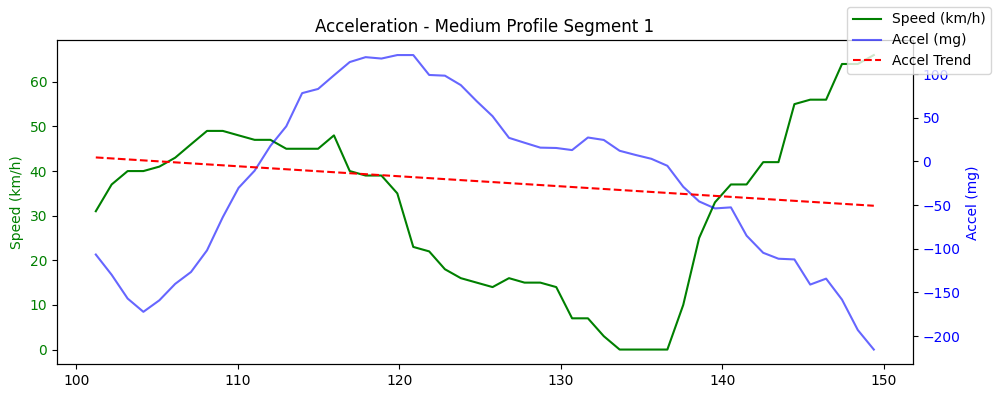

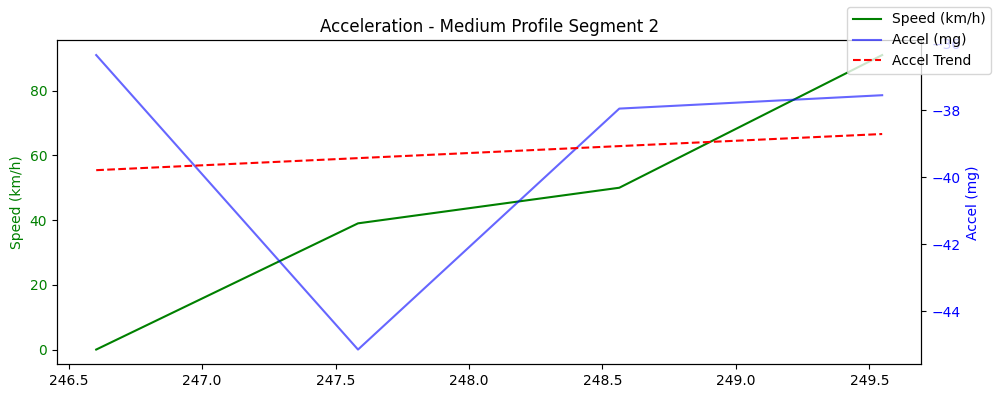

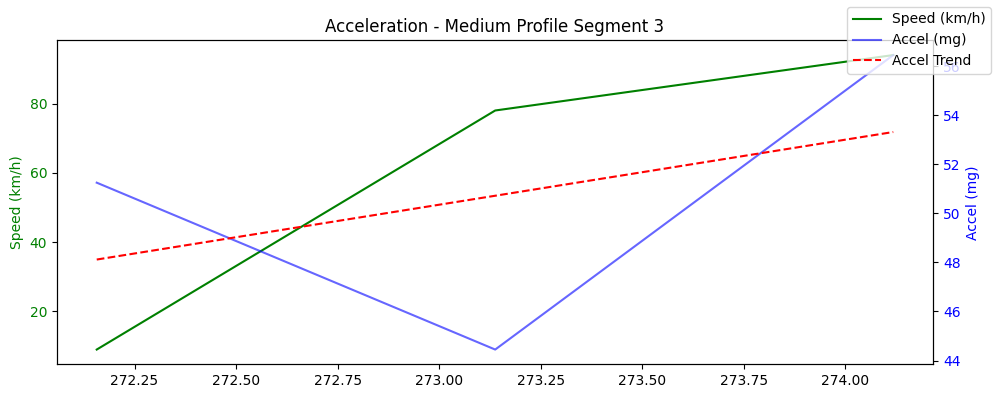

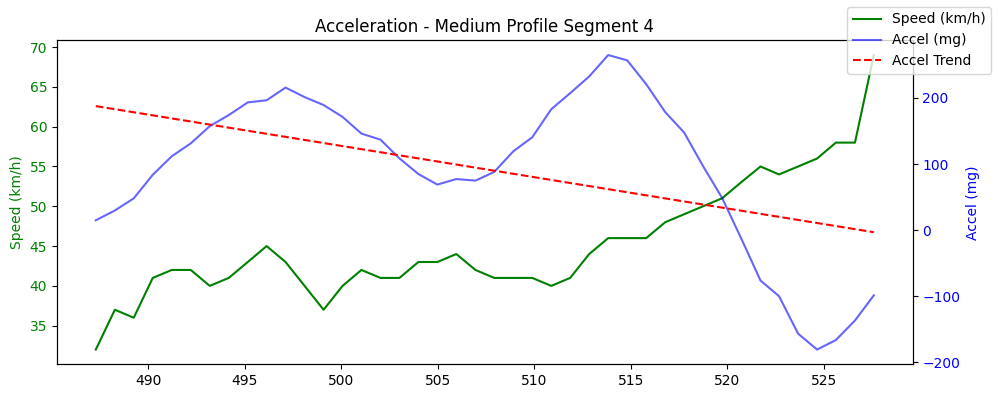

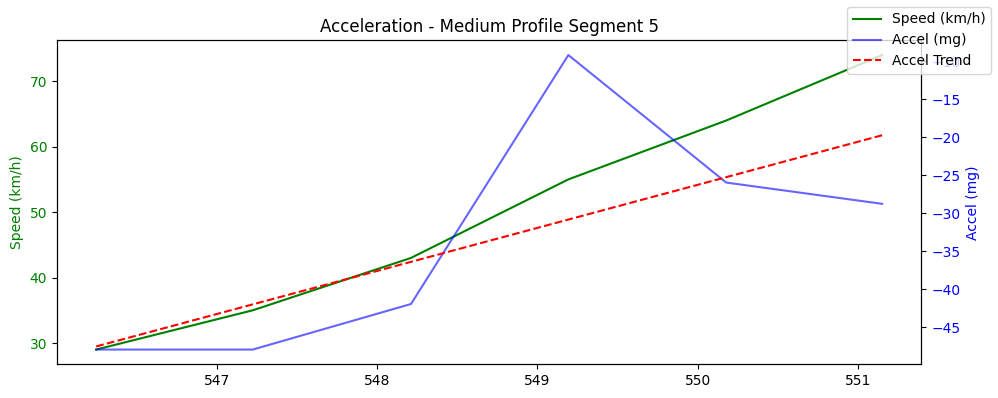

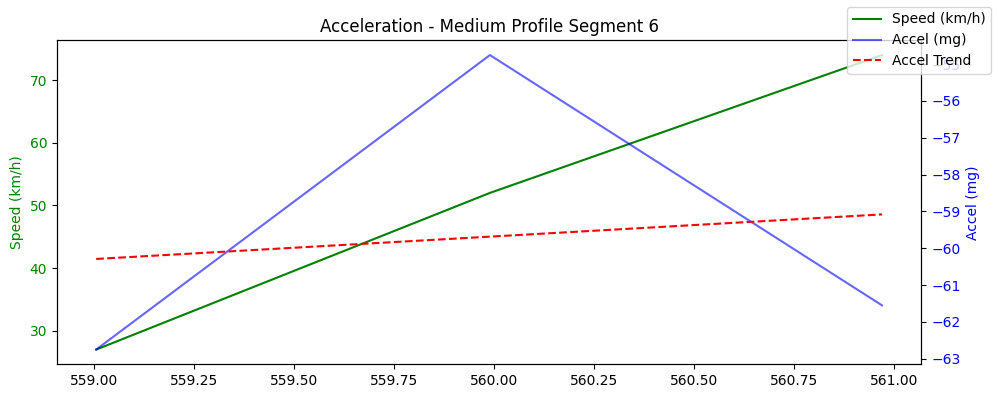

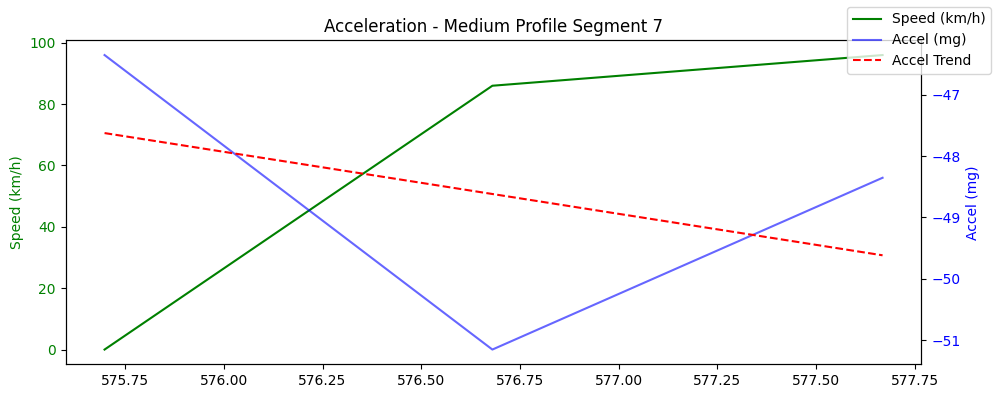

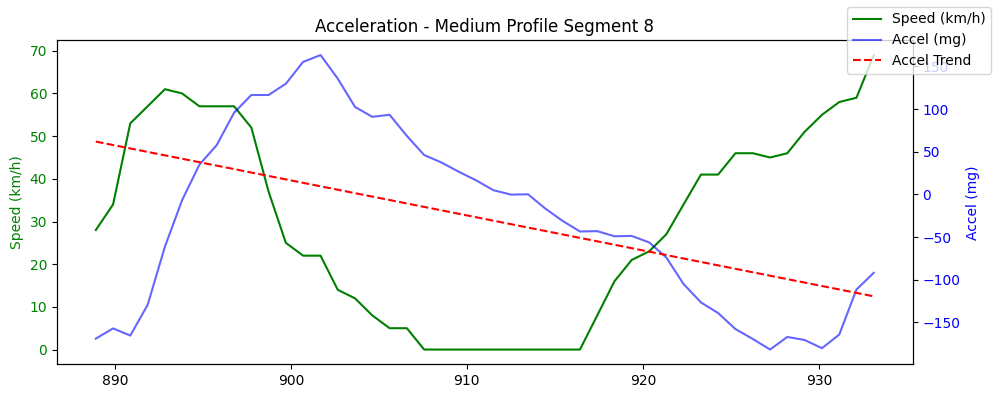

Found 5 segments for acceleration profile: large


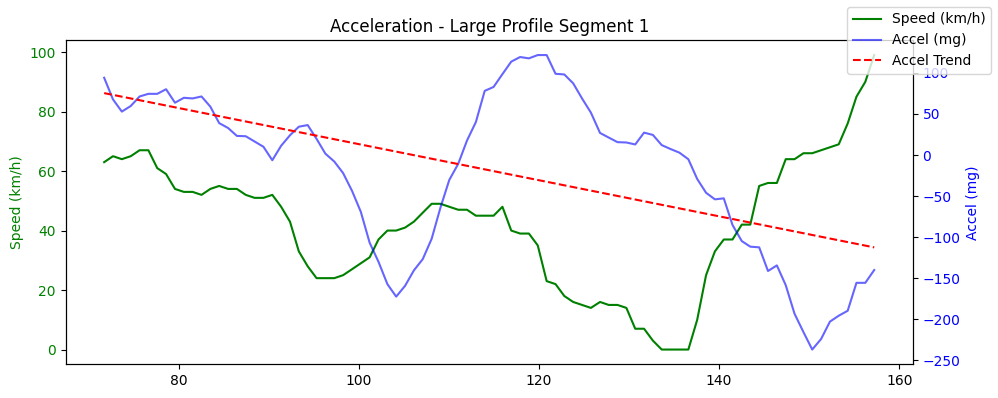

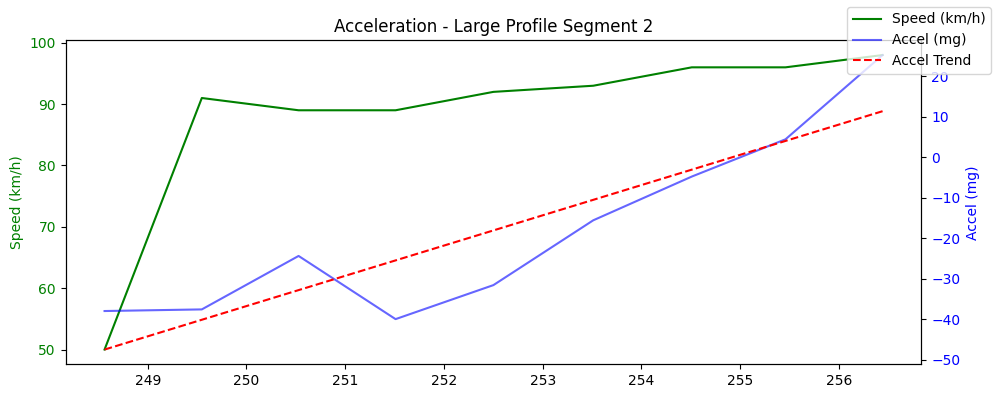

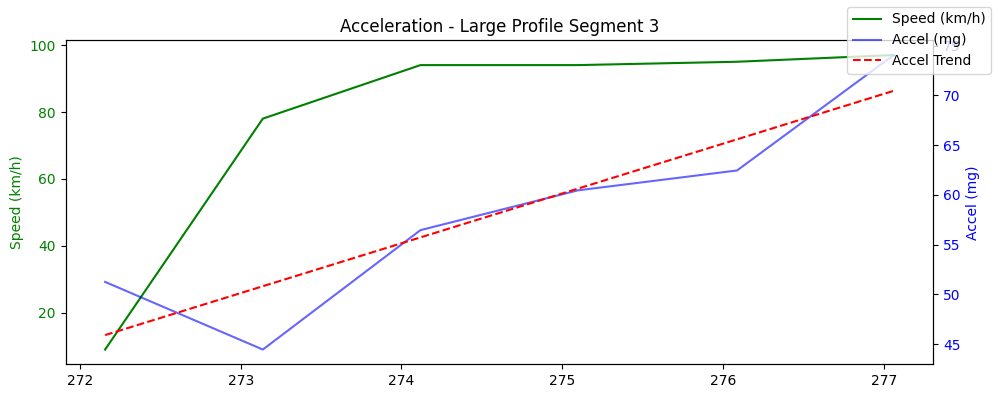

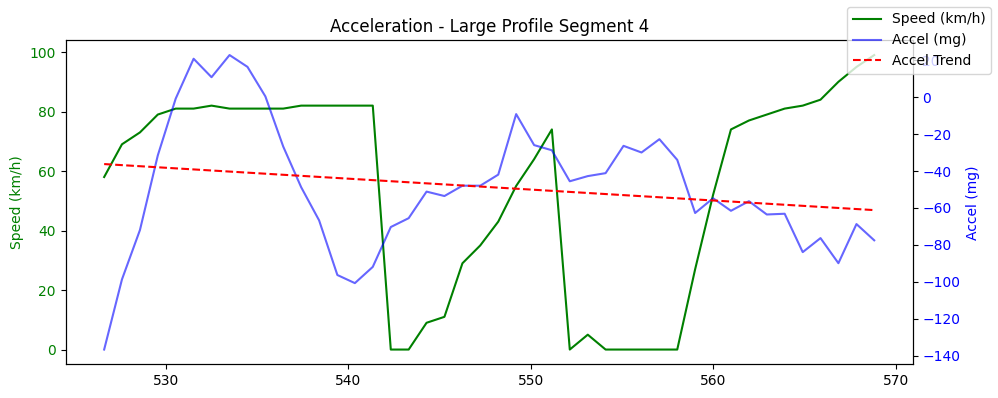

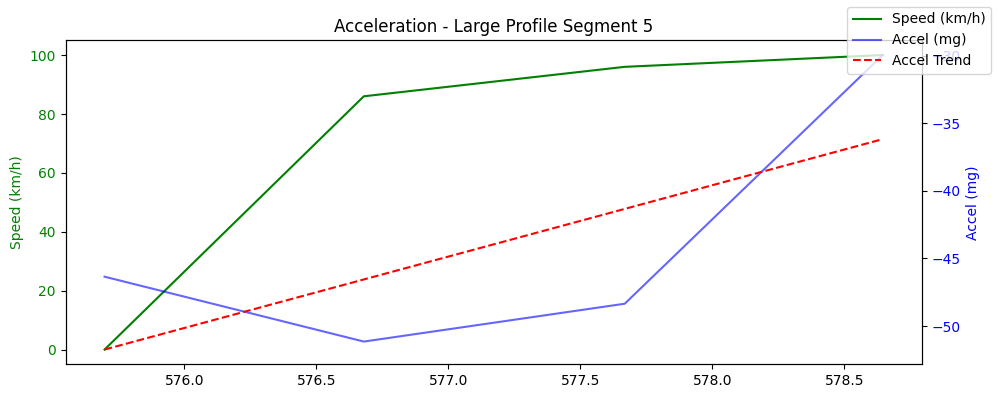

Found 9 segments for deceleration profile: small


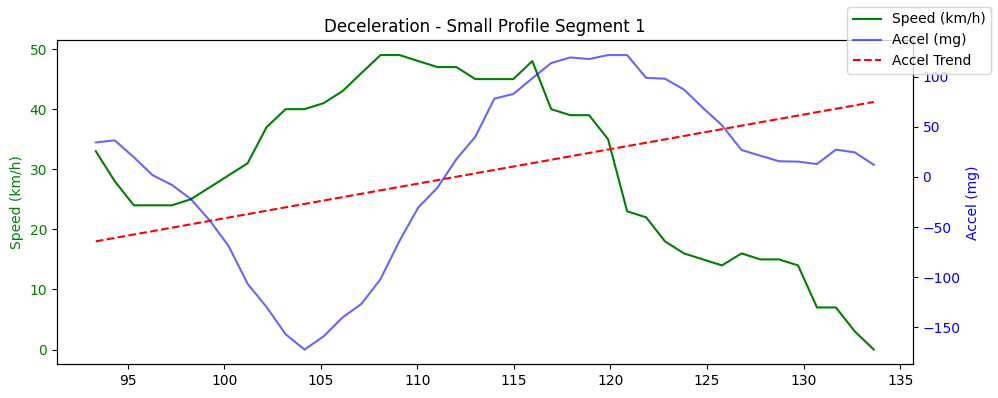

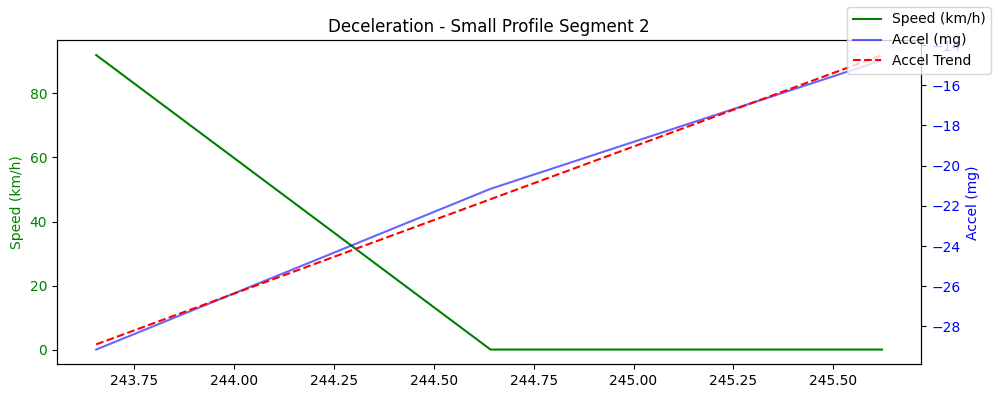

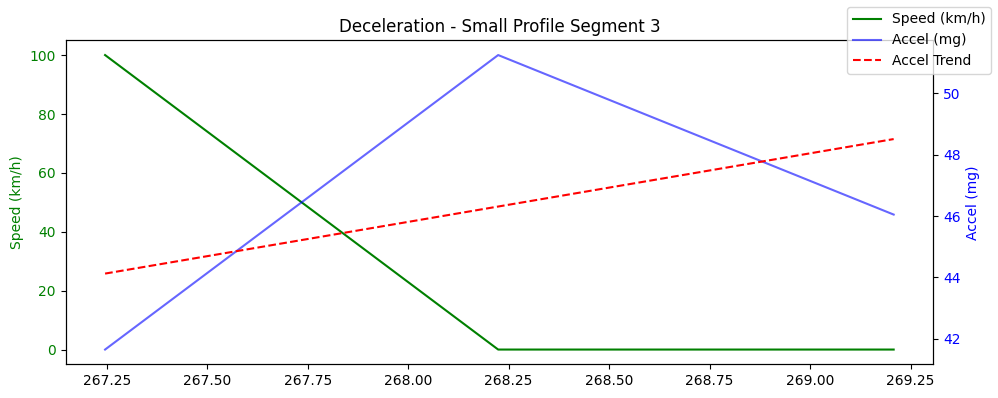

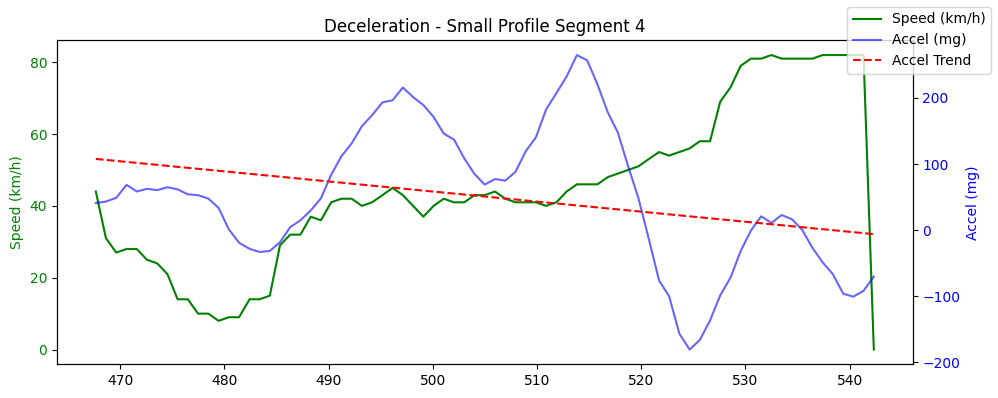

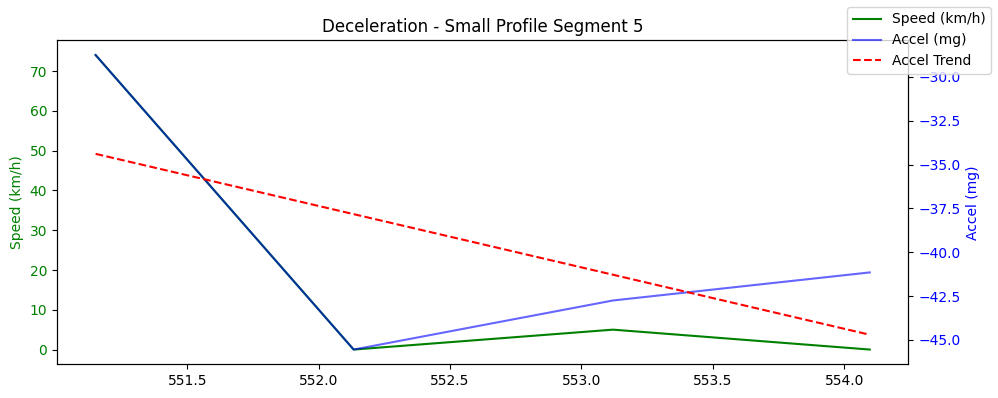

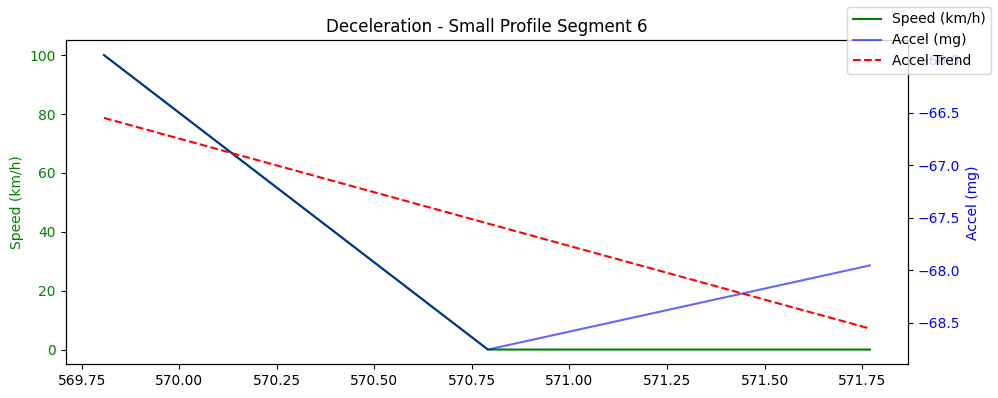

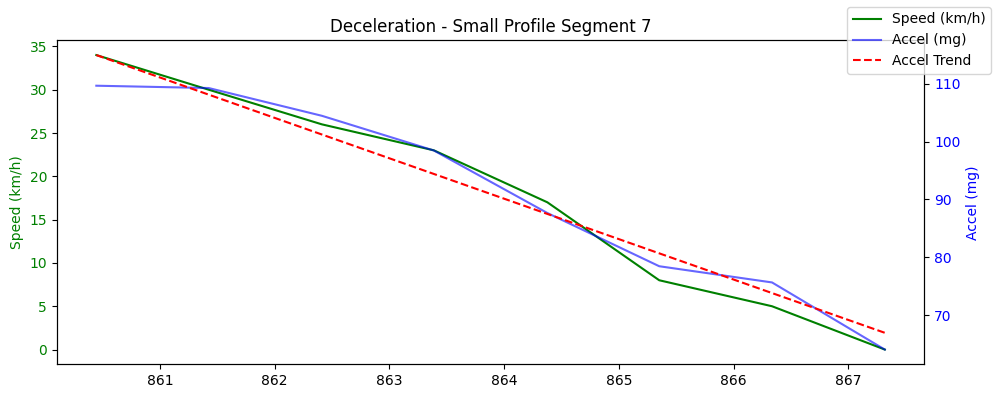

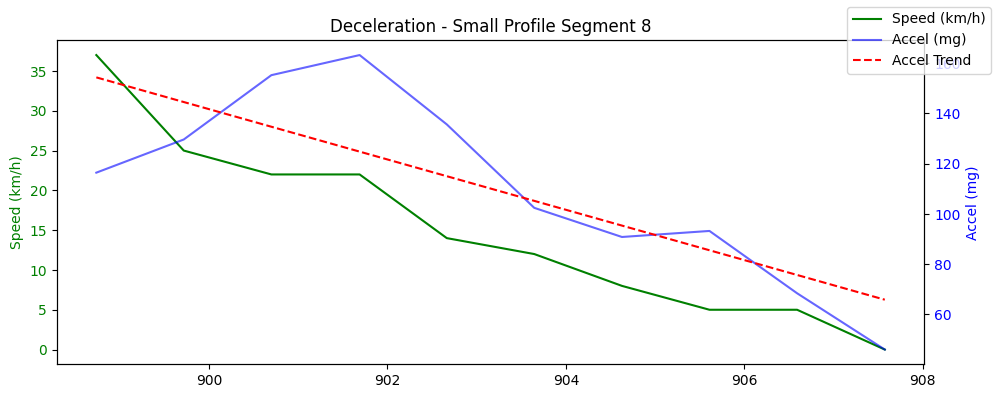

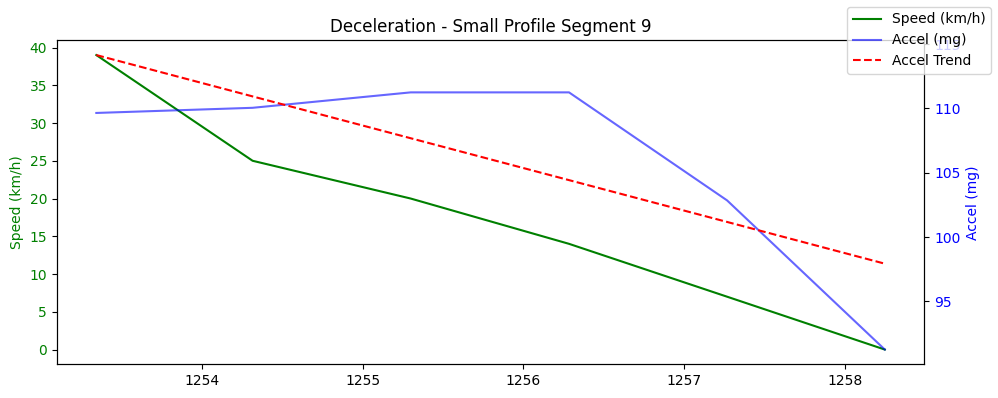

Found 9 segments for deceleration profile: medium


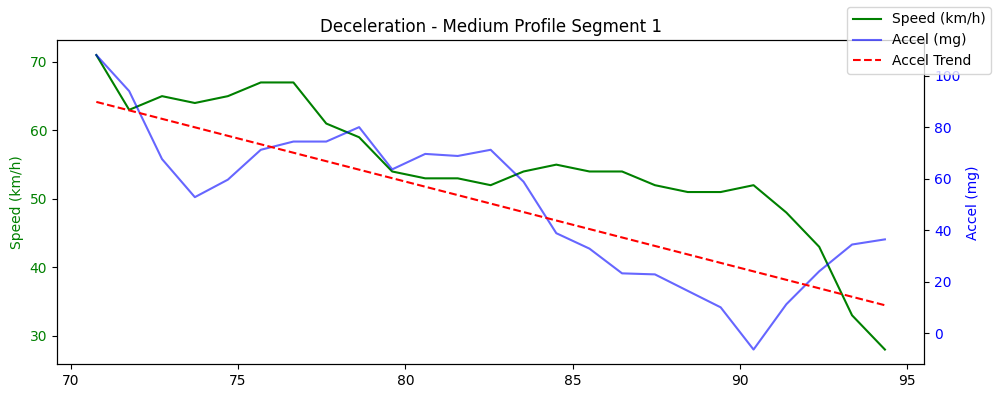

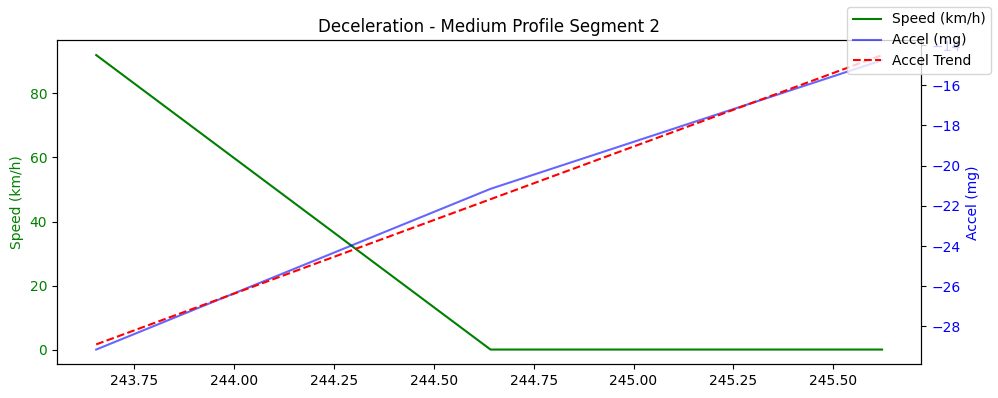

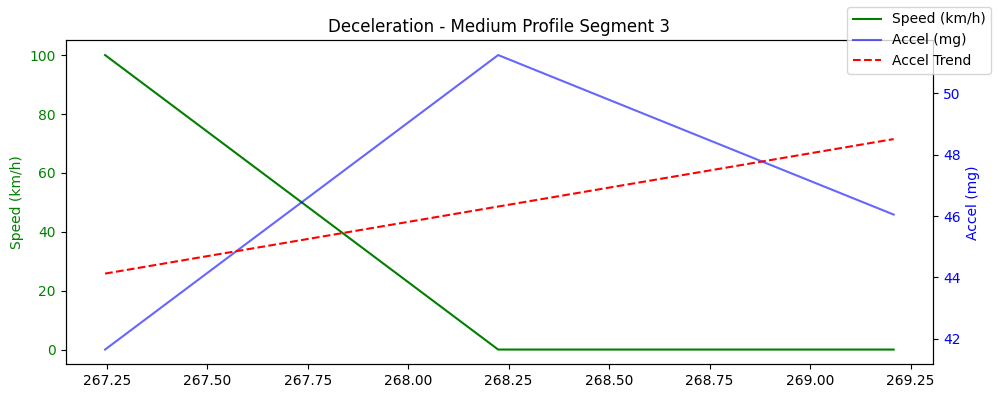

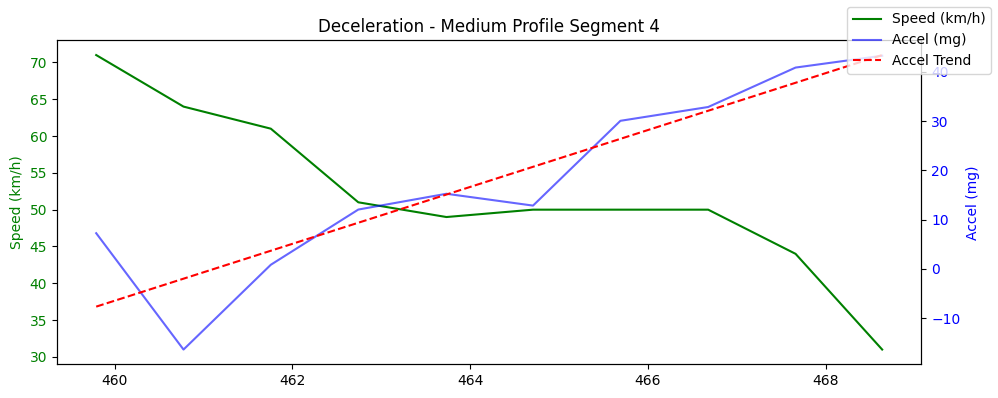

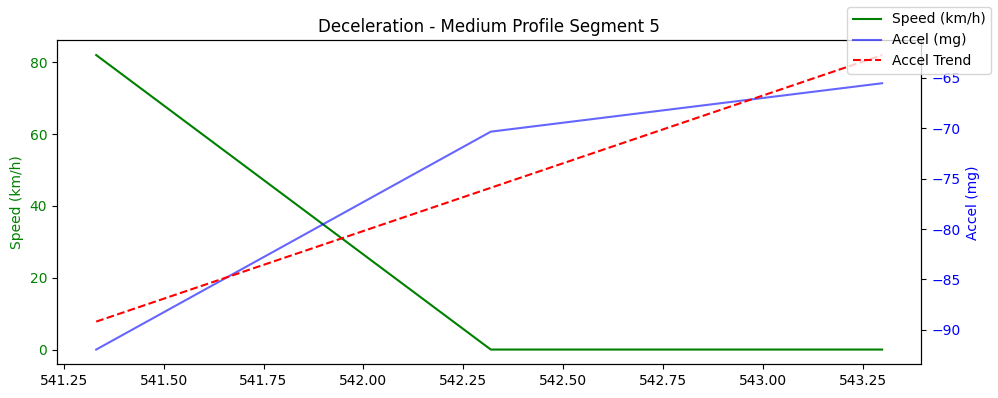

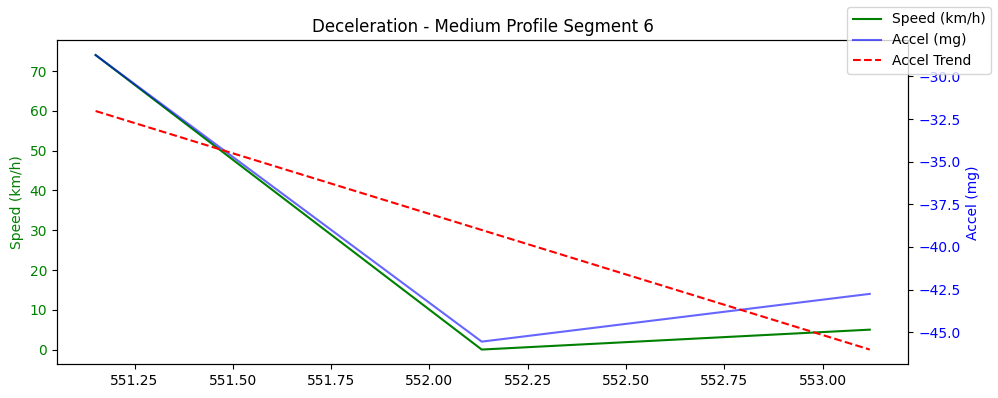

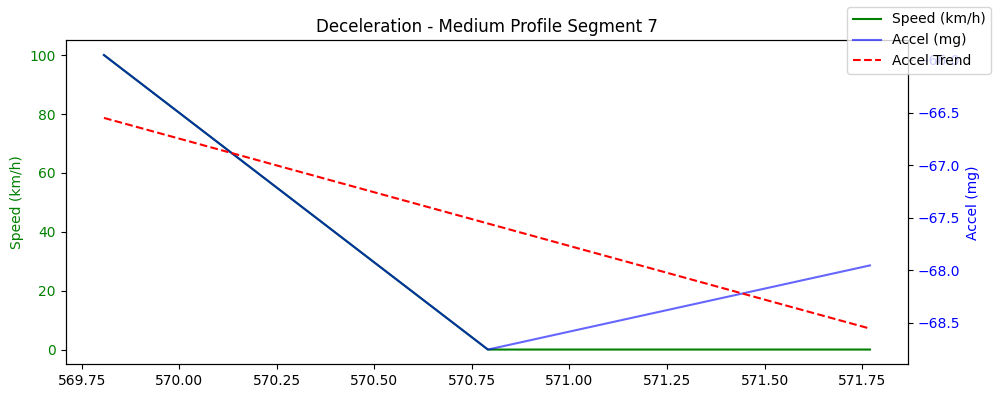

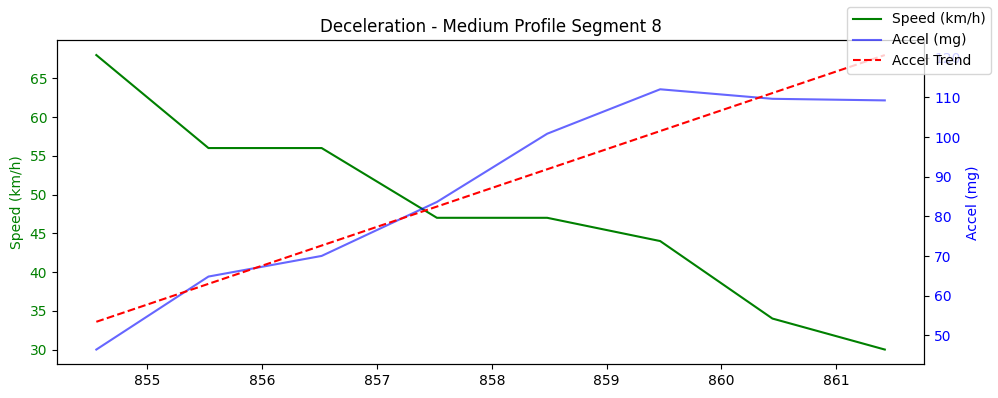

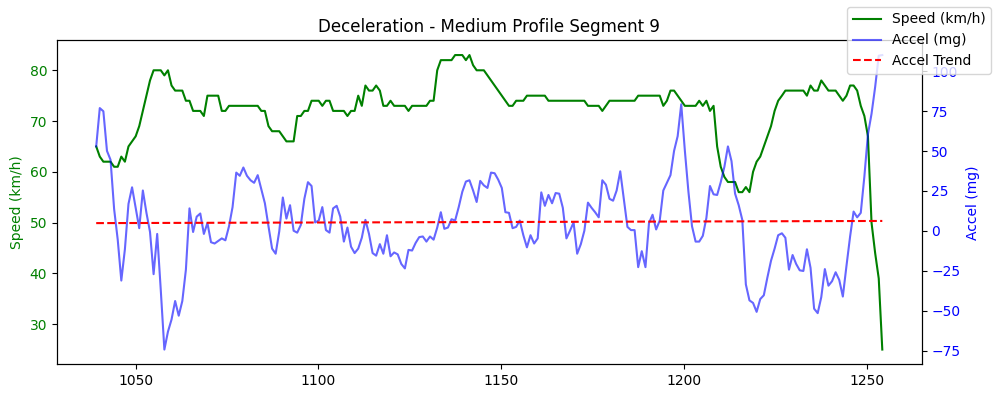

Found 5 segments for deceleration profile: large


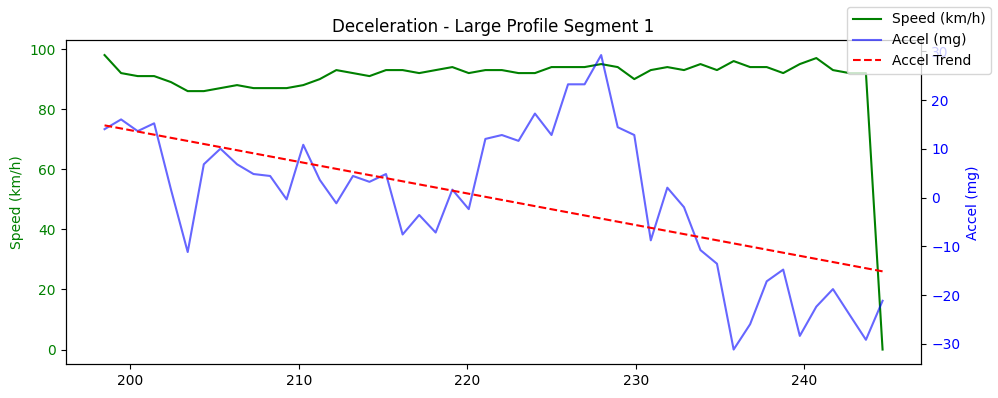

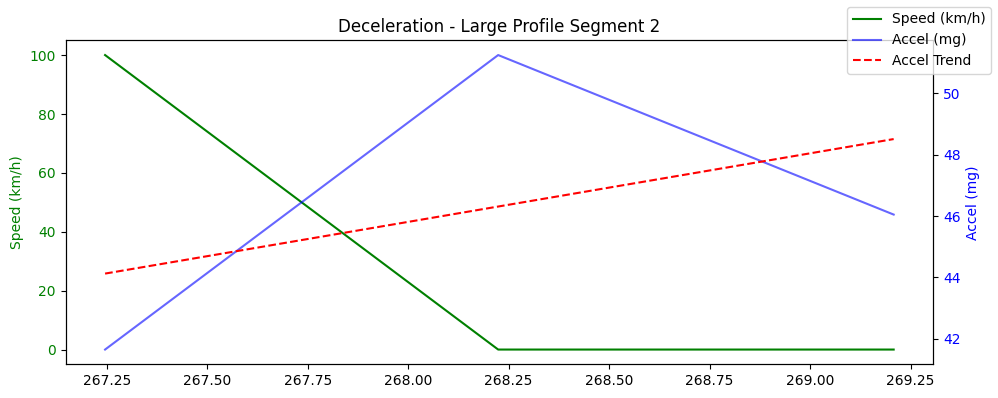

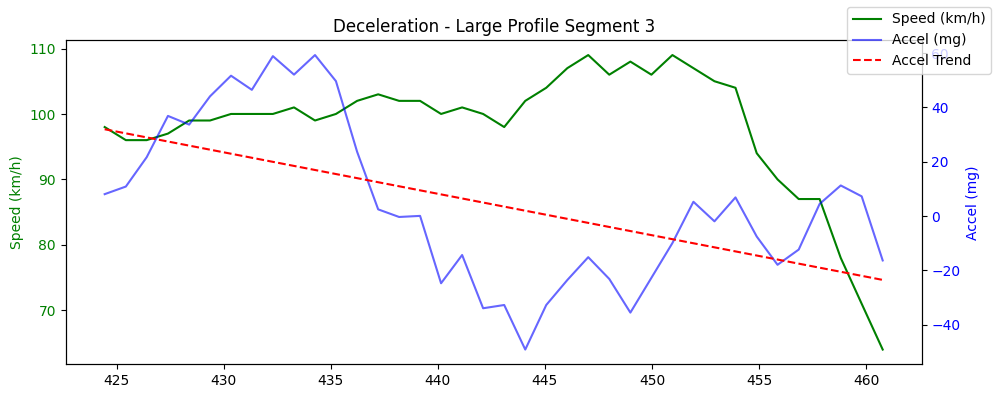

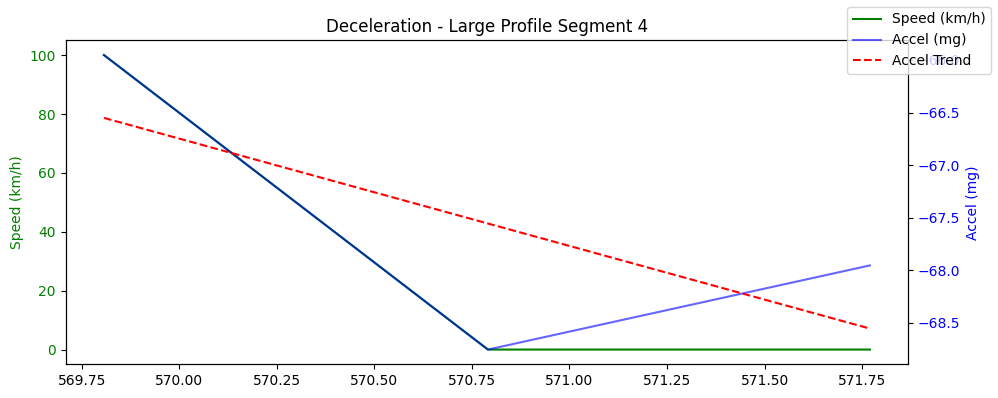

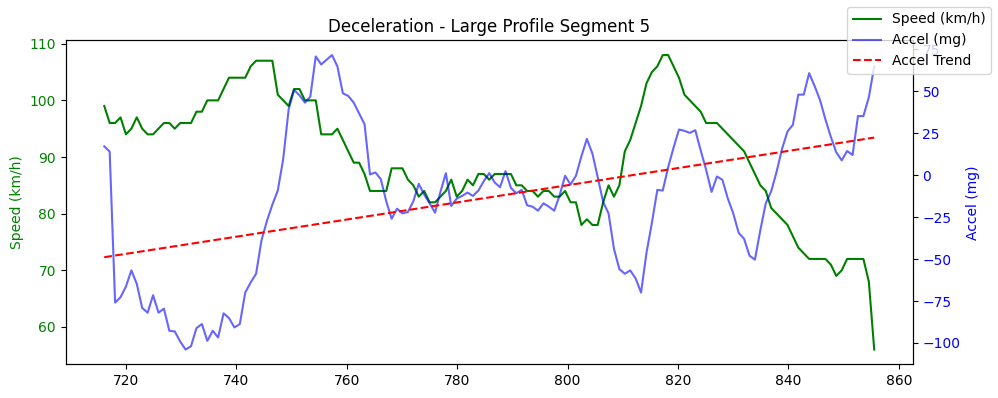

Direction  Mean Acceleration (mg)  \
Profile Segment                                               
acceleration_medium_1  acceleration              -23.233577   
acceleration_medium_2  acceleration              -39.253577   
acceleration_medium_3  acceleration               50.713090   
acceleration_medium_4  acceleration               92.179757   
acceleration_medium_5  acceleration              -33.620243   
acceleration_medium_6  acceleration              -59.686910   
acceleration_medium_7  acceleration              -48.620243   
acceleration_medium_8  acceleration              -28.875316   
acceleration_large_1   acceleration              -18.544486   
acceleration_large_2   acceleration              -17.998021   
acceleration_large_3   acceleration               58.179757   
acceleration_large_4   acceleration              -48.708122   
acceleration_large_5   acceleration              -43.953577   
deceleration_small_1   deceleration                5.265471   
deceleration_small_2   deceleration              -21.686910   
deceleration_small_3   deceleration               46.313090   
deceleration_small_4   deceleration               50.773696   
deceleration_small_5   deceleration              -39.553577   
deceleration_small_6   deceleration              -67.553577   
deceleration_small_7   deceleration               90.946423   
deceleration_small_8   deceleration              110.126423   
deceleration_small_9   deceleration              106.046423   
deceleration_medium_1  deceleration               50.350423   
deceleration_medium_2  deceleration              -21.686910   
deceleration_medium_3  deceleration               46.313090   
deceleration_medium_4  deceleration               17.886423   
deceleration_medium_5  deceleration              -75.953577   
deceleration_medium_6  deceleration              -39.020243   
deceleration_medium_7  deceleration              -67.553577   
deceleration_medium_8  deceleration               87.096423   
deceleration_medium_9  deceleration                5.493696   
deceleration_large_1   deceleration               -0.145243   
deceleration_large_2   deceleration               46.313090   
deceleration_large_3   deceleration                4.204318   
deceleration_large_4   deceleration              -67.553577   
deceleration_large_5   deceleration              -13.226304   

                       Std Acceleration (mg)  Duration (s)  \
Profile Segment                                              
acceleration_medium_1              97.311551        48.153   
acceleration_medium_2               3.991658         2.945   
acceleration_medium_3               6.017752         1.961   
acceleration_medium_4             120.302437        40.282   
acceleration_medium_5              15.240822         4.904   
acceleration_medium_6               4.314317         1.964   
acceleration_medium_7               2.411086         1.970   
acceleration_medium_8             107.041404        44.193   
acceleration_large_1               97.651597        85.475   
acceleration_large_2               22.477940         7.879   
acceleration_large_3               10.146658         4.904   
acceleration_large_4               34.840363        42.222   
acceleration_large_5                9.538693         2.947   
deceleration_small_1               85.697048        40.282   
deceleration_small_2                7.214800         1.967   
deceleration_small_3                4.805552         1.962   
deceleration_small_4              105.255713        74.659   
deceleration_small_5                7.426080         2.946   
deceleration_small_6                1.442221         1.963   
deceleration_small_7               17.104385         6.872   
deceleration_small_8               37.251243         8.837   
deceleration_small_9                7.903417         4.909   
deceleration_medium_1              28.936777        23.572   
deceleration_medium_2               7.214800         1.967   
deceleration_medium

In [69]:
def analyze_all_profiles(df, display_plots=True):
    """
    Analyze all acceleration and deceleration profiles (small, medium, large).
    Returns a combined summary DataFrame.
    """
    summary_parts = []
    profiles = ['small', 'medium', 'large']
    directions = ['acceleration', 'deceleration']

    for direction in directions:
        for profile in profiles:
            result_df = extract_profiles(df, profile, direction=direction, display_plots=display_plots)
            if not result_df.empty:
                summary_parts.append(result_df)

    if summary_parts:
        combined_summary = pd.concat(summary_parts)
        display(combined_summary)
        return combined_summary
    else:
        print("No valid segments found.")
        return pd.DataFrame()
    
# Just run this one-liner:
summary_df = analyze_all_profiles(dataset1)

# Stop and Go

In [70]:
# Check available columns first (optional but helpful)
print(dataset1.columns)

# Detect possible STOP transitions: from speed > 1 to speed <= 1
stop_candidates = dataset1[
    (dataset1['Speed_kmh'].shift(1) > 1) & (dataset1['Speed_kmh'] <= 1)
]

print(f"Detected {len(stop_candidates)} possible stop transition points.")
display(stop_candidates.head())

Index(['Timestamp', 'Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'GPS_Fix',
       'Speed_kmh', 'Speed_Label', 'X_filt', 'X_centered', 'Elapsed_s',
       'Event'],
      dtype='object')
Detected 10 possible stop transition points.


Timestamp  Accel_X_g  Accel_Y_g  Accel_Z_g  GPS_Fix  \
136 2025-07-02 10:56:17.593       32.0       64.0     1028.0        1   
249 2025-07-02 10:58:08.599      128.0       16.0     1024.0        0   
273 2025-07-02 10:58:32.181      276.0       16.0     1108.0        0   
552 2025-07-02 11:03:06.276      196.0      -88.0     1196.0        0   
562 2025-07-02 11:03:16.090       28.0      -60.0      936.0        0   

     Speed_kmh Speed_Label  X_filt  X_centered  Elapsed_s         Event  
136        0.0        Slow   112.0   12.046423    133.636      Cruising  
249        0.0        Slow    78.8  -21.153577    244.642       Braking  
273        0.0        Slow   151.2   51.246423    268.224  Accelerating  
552        0.0        Slow    29.6  -70.353577    542.319       Braking  
562        0.0        Slow    54.4  -45.553577    552.133       Braking

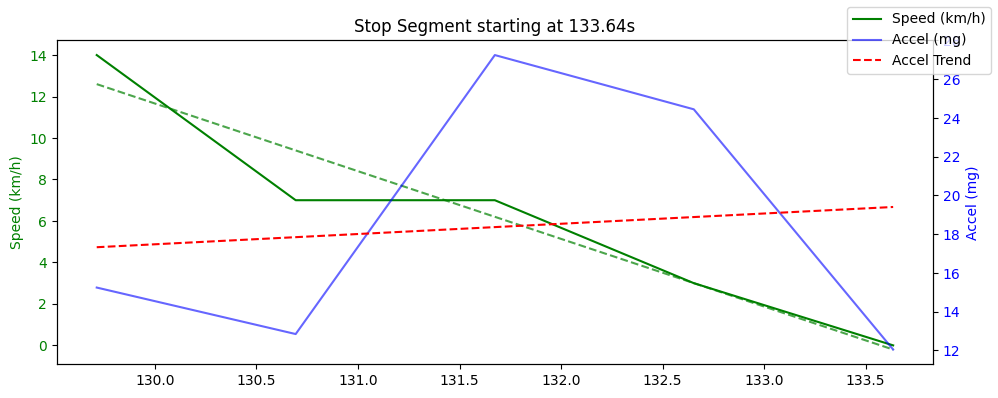

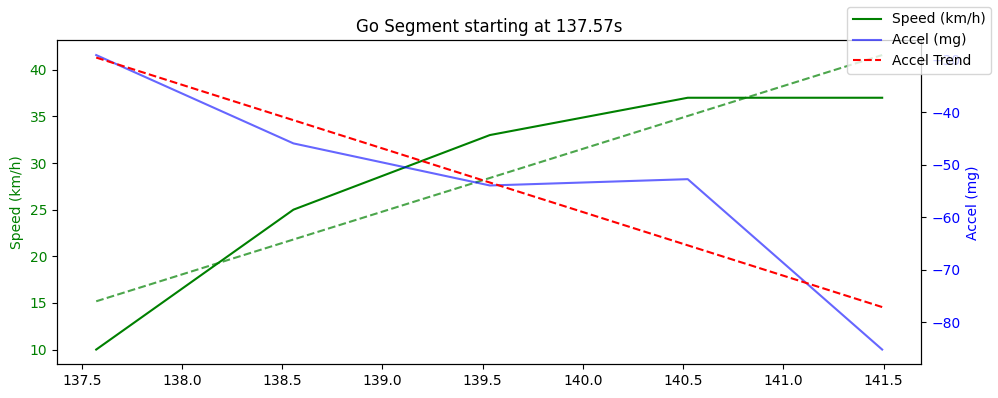

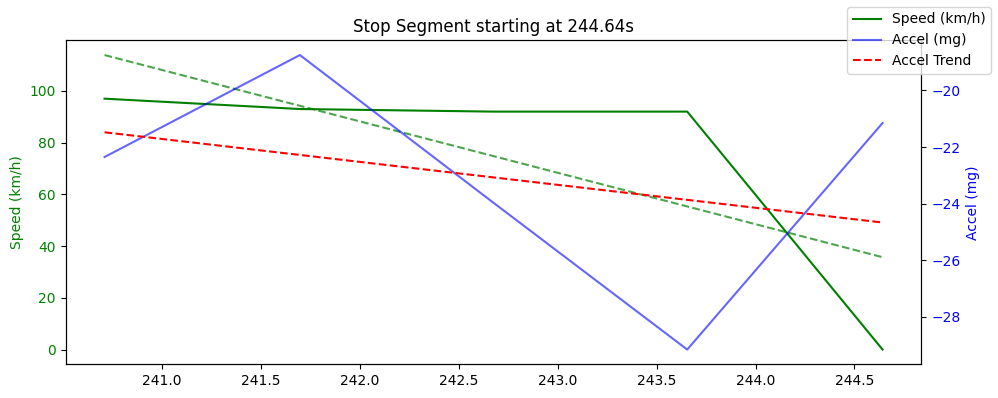

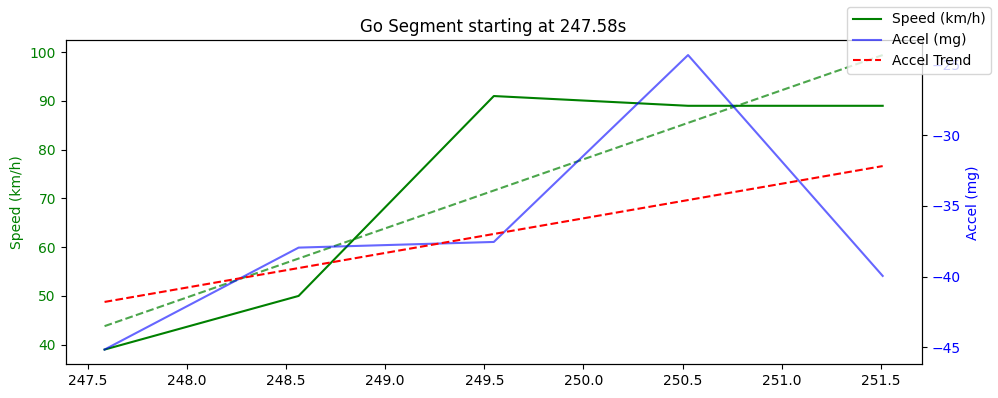

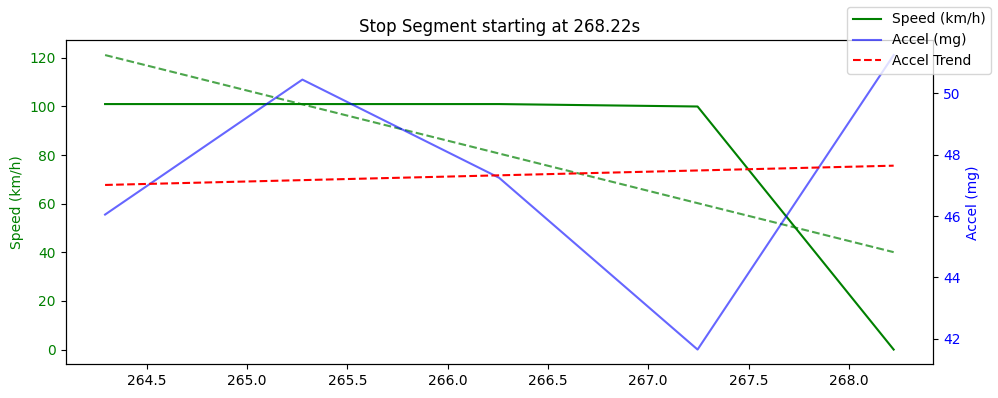

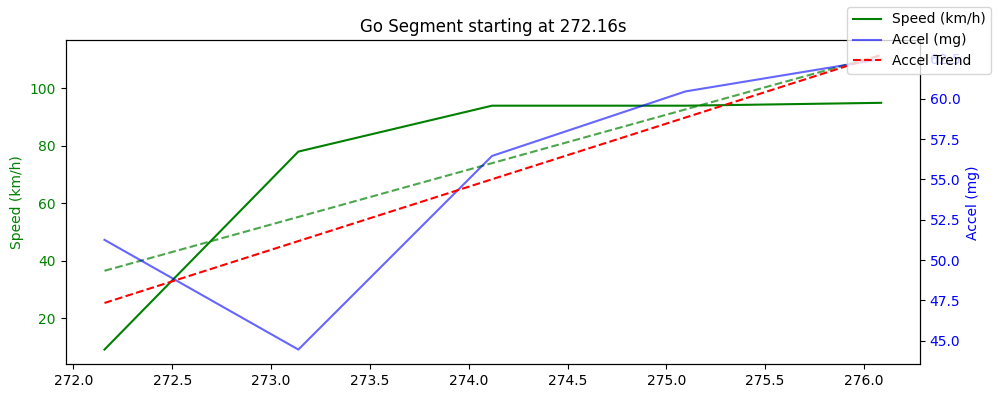

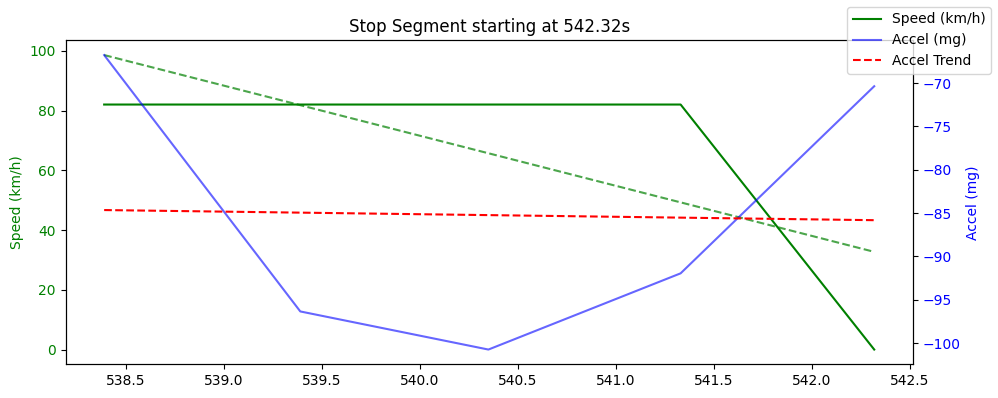

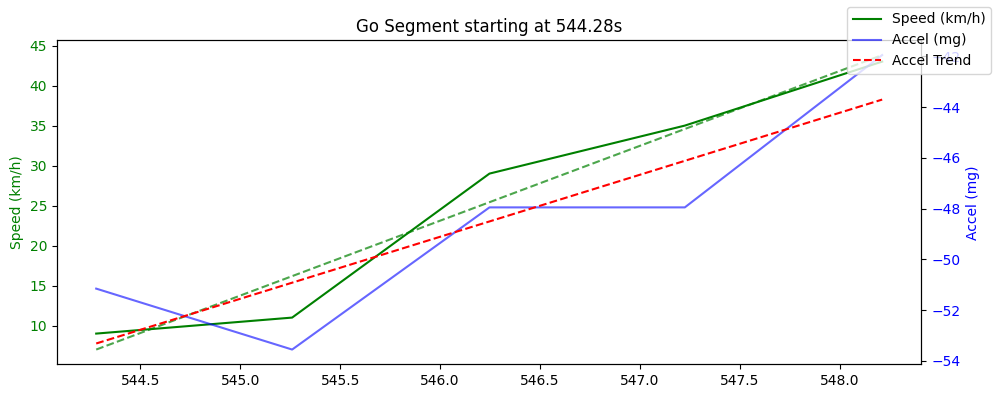

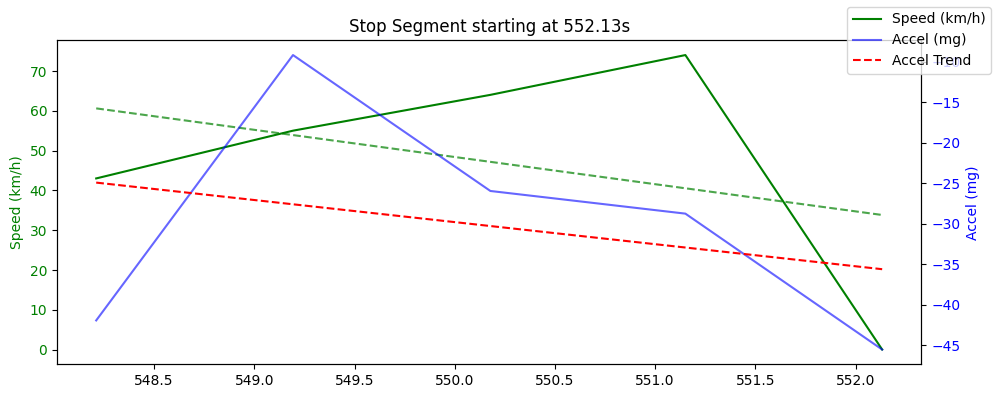

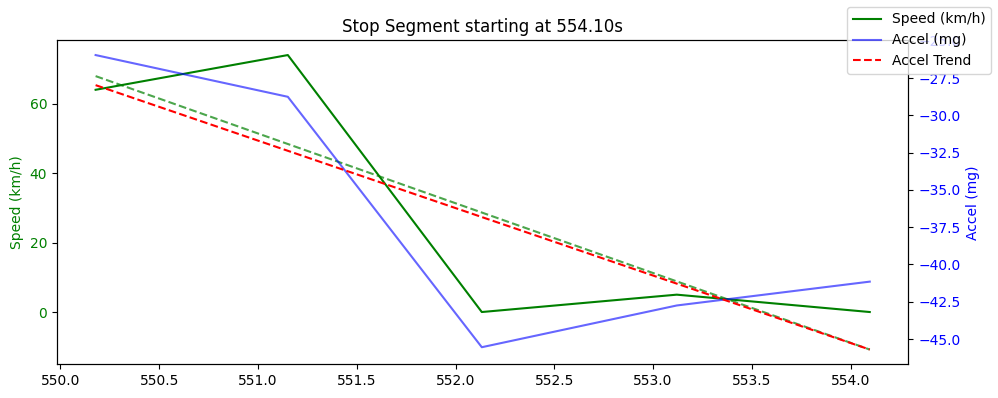

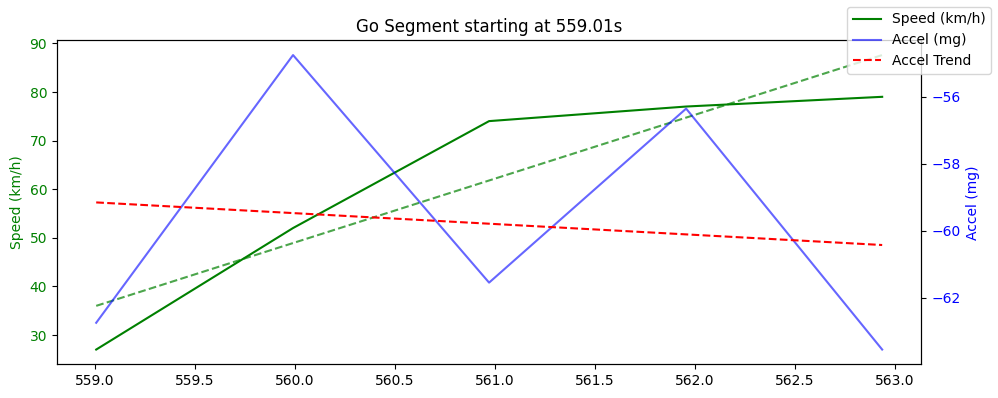

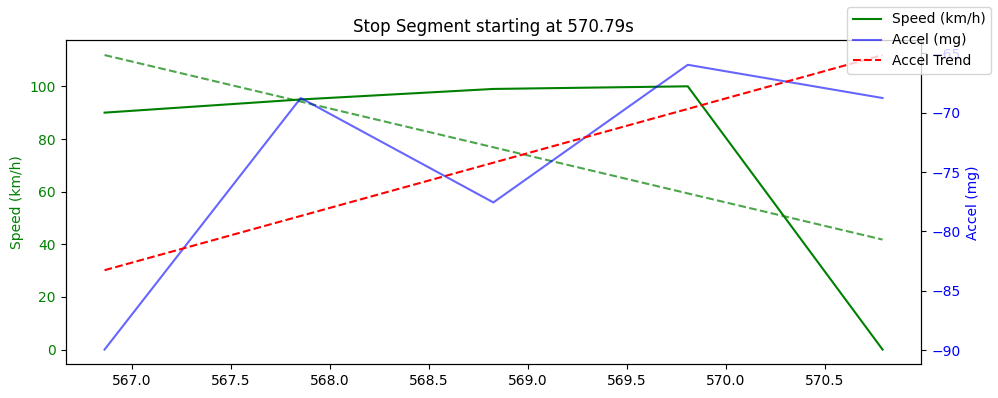

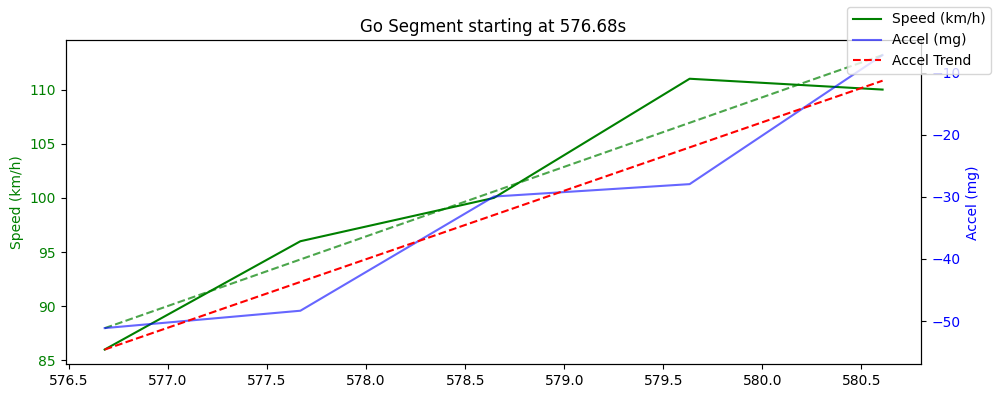

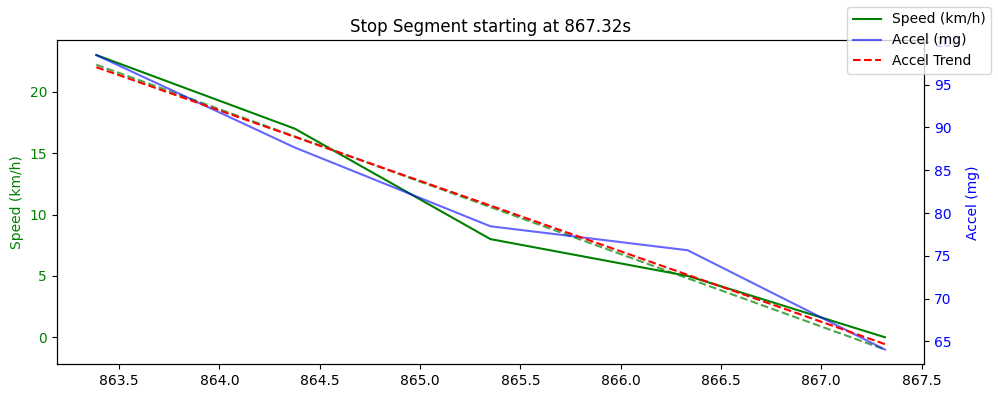

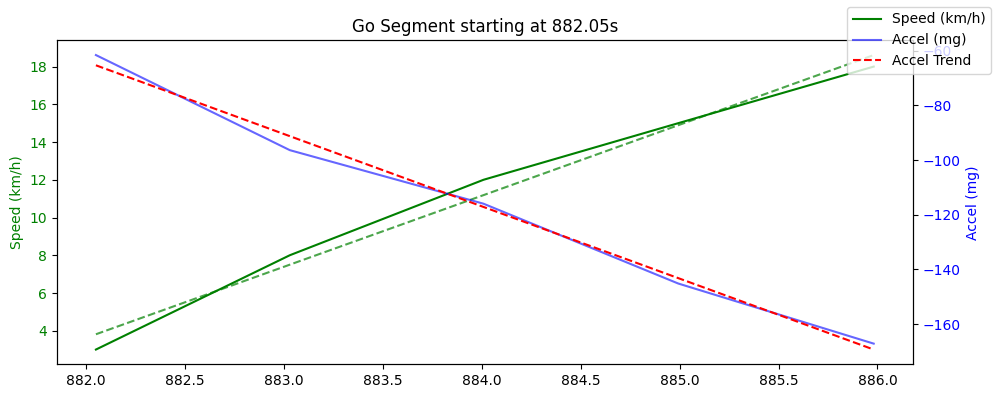

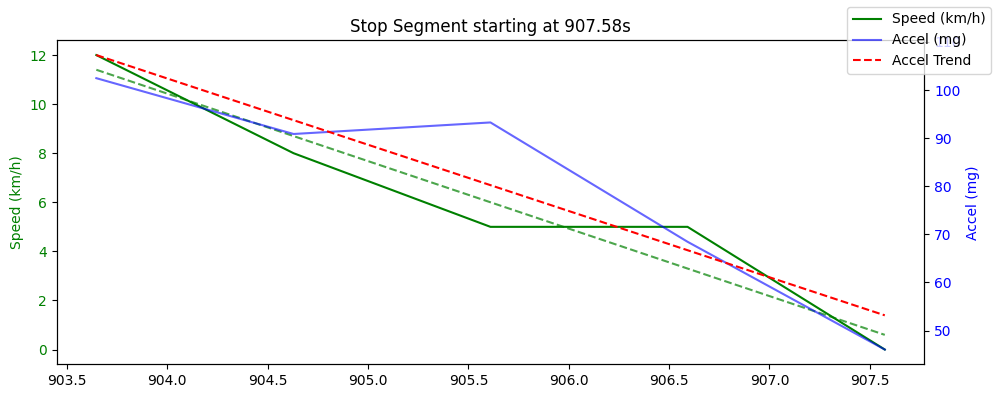

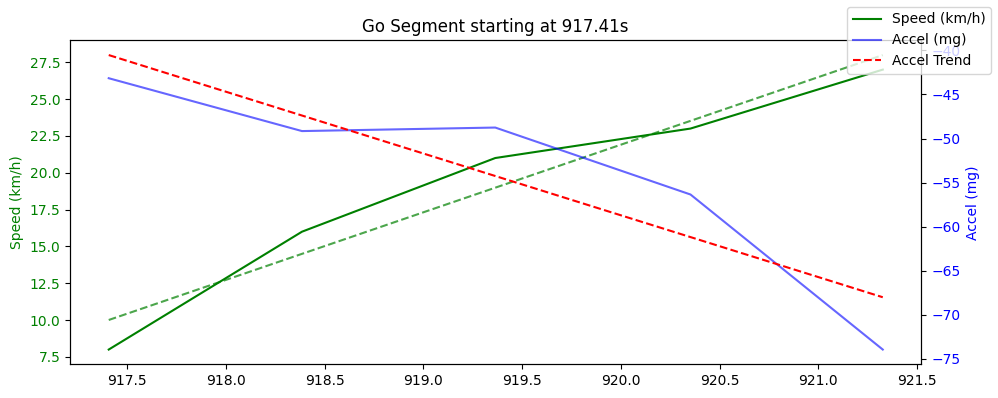

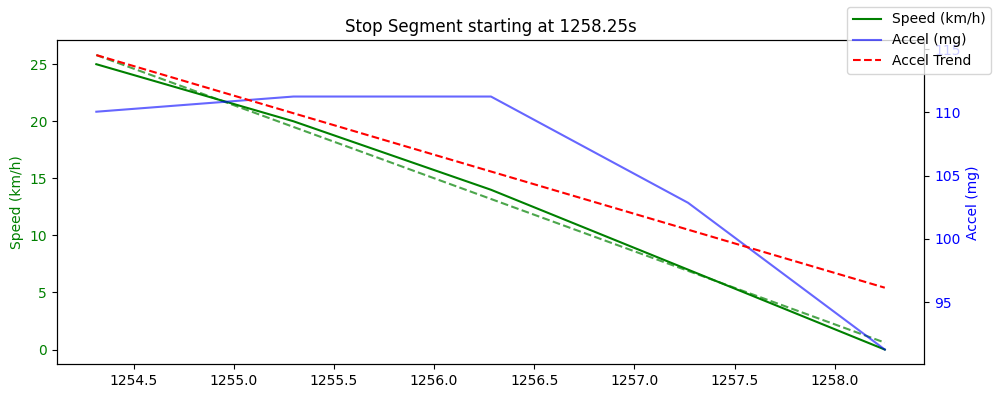

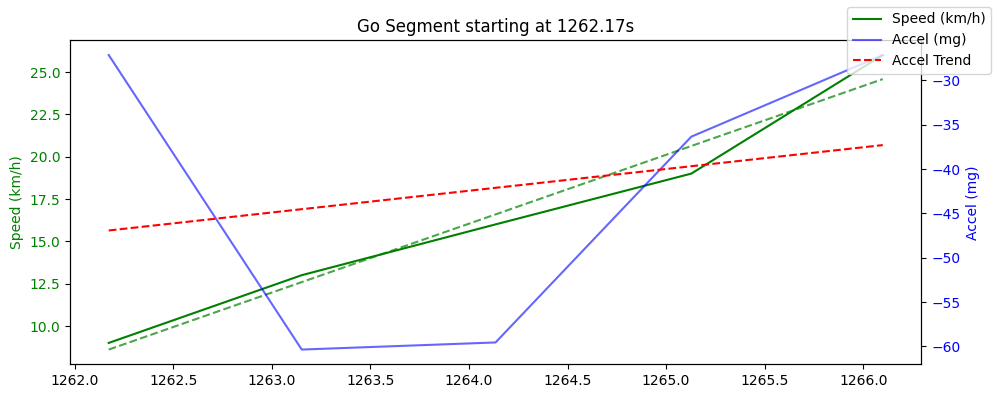

GO Segments:


Type  Segment Start Time (s)  Duration (s)  Start Speed (km/h)  \
0   Go                 137.572         3.921                10.0   
1   Go                 247.584         3.926                39.0   
2   Go                 272.157         3.930                 9.0   
3   Go                 544.280         3.931                 9.0   
4   Go                 559.006         3.929                27.0   
5   Go                 576.680         3.927                86.0   
6   Go                 882.050         3.931                 3.0   
7   Go                 917.406         3.921                 8.0   
8   Go                1262.173         3.926                 9.0   

   End Speed (km/h)  Start Accel (mg)  End Accel (mg)  Mean Accel (mg)  \
0              37.0        -29.153577      -85.153577       -53.393577   
1              89.0        -45.153577      -39.953577       -36.993577   
2              95.0         51.246423       62.446423        55.006423   
3              43.0        -51.153577      -41.953577       -48.513577   
4              79.0        -62.753577      -63.553577       -59.793577   
5             110.0        -51.153577       -7.153577       -32.913577   
6              18.0        -61.553577     -167.153577      -117.233577   
7              27.0        -43.153577      -73.953577       -54.273577   
8              26.0        -27.153577      -27.153577       -42.113577   

   Std Accel (mg)  
0       20.324566  
1        7.686872  
2        7.291639  
3        4.359817  
4        3.975928  
5       17.804718  
6       41.259569  
7       11.957926  
8       16.715502

STOP Segments:


Type  Segment Start Time (s)  Duration (s)  Start Speed (km/h)  \
0  Stop                 133.636         3.923                14.0   
1  Stop                 244.642         3.931                97.0   
2  Stop                 268.224         3.933               101.0   
3  Stop                 542.319         3.930                82.0   
4  Stop                 552.133         3.922                43.0   
5  Stop                 554.097         3.919                64.0   
6  Stop                 570.791         3.930                90.0   
7  Stop                 867.317         3.930                23.0   
8  Stop                 907.575         3.929                12.0   
9  Stop                1258.250         3.936                25.0   

   End Speed (km/h)  Start Accel (mg)  End Accel (mg)  Mean Accel (mg)  \
0               0.0         15.246423       12.046423        18.366423   
1               0.0        -22.353577      -21.153577       -23.073577   
2               0.0         46.046423       51.246423        47.326423   
3               0.0        -66.753577      -70.353577       -85.233577   
4               0.0        -41.953577      -45.553577       -30.273577   
5               0.0        -25.953577      -41.153577       -36.833577   
6               0.0        -89.953577      -68.753577       -74.193577   
7               0.0         98.446423       64.046423        80.846423   
8               0.0        102.446423       46.046423        80.206423   
9               0.0        110.046423       91.246423       105.326423   

   Std Accel (mg)  
0        6.999429  
1        3.892557  
2        3.840833  
3       15.593332  
4       14.464854  
5        8.851667  
6        9.833006  
7       12.952220  
8       22.820342  
9        8.613478

In [71]:
def analyze_segment(segment, start_time, label, display_plots):
    duration = segment['Elapsed_s'].iloc[-1] - segment['Elapsed_s'].iloc[0]
    accel_mean = segment['X_centered'].mean()
    accel_std = segment['X_centered'].std()
    speed_start = segment['Speed_kmh'].iloc[0]
    speed_end = segment['Speed_kmh'].iloc[-1]
    accel_start = segment['X_centered'].iloc[0]
    accel_end = segment['X_centered'].iloc[-1]

    if display_plots:
        fig, ax1 = plt.subplots(figsize=(10, 4))
        ax2 = ax1.twinx()

        ax1.plot(segment['Elapsed_s'], segment['Speed_kmh'], 'g-', label='Speed (km/h)')
        ax1.set_ylabel('Speed (km/h)', color='g')
        ax1.tick_params(axis='y', labelcolor='g')

        ax2.plot(segment['Elapsed_s'], segment['X_centered'], 'b-', alpha=0.6, label='Accel (mg)')
        ax2.set_ylabel('Accel (mg)', color='b')
        ax2.tick_params(axis='y', labelcolor='b')

        if segment['Elapsed_s'].nunique() > 1:
            from scipy.stats import linregress
            slope_speed, intercept_speed, *_ = linregress(segment['Elapsed_s'], segment['Speed_kmh'])
            ax1.plot(segment['Elapsed_s'], slope_speed * segment['Elapsed_s'] + intercept_speed, 'g--', alpha=0.7)

            slope_accel, intercept_accel, *_ = linregress(segment['Elapsed_s'], segment['X_centered'])
            ax2.plot(segment['Elapsed_s'], slope_accel * segment['Elapsed_s'] + intercept_accel, 'r--', label='Accel Trend')

        plt.title(f"{label} Segment starting at {start_time:.2f}s")
        fig.tight_layout()
        fig.legend(loc='upper right')
        plt.show()

    return {
        'Type': label,
        'Segment Start Time (s)': start_time,
        'Duration (s)': duration,
        'Start Speed (km/h)': speed_start,
        'End Speed (km/h)': speed_end,
        'Start Accel (mg)': accel_start,
        'End Accel (mg)': accel_end,
        'Mean Accel (mg)': accel_mean,
        'Std Accel (mg)': accel_std
    }

def stop_and_go_analysis_v5(df, display_plots=True):
    """
    Analyze stop-and-go events.
    GO: From ~0 to motion
    STOP: From motion to ~0
    """
    go_summaries = []
    stop_summaries = []

    for i in range(1, len(df)):
        prev_speed = df.iloc[i - 1]['Speed_kmh']
        curr_speed = df.iloc[i]['Speed_kmh']
        curr_time = df.iloc[i]['Elapsed_s']

        # === GO Segment === (vehicle starts moving)
        if prev_speed <= 1.0 and curr_speed > 1.0:
            segment = df.iloc[i:i + 5].copy()
            if len(segment) > 1 and segment['Speed_kmh'].iloc[-1] > segment['Speed_kmh'].iloc[0]:
                go_summaries.append(analyze_segment(segment, curr_time, 'Go', display_plots))

        # === STOP Segment === (vehicle stops)
        if prev_speed > 1.0 and curr_speed <= 1.0:
            segment = df.iloc[max(0, i - 4):i + 1].copy()
            if len(segment) > 1 and segment['Speed_kmh'].iloc[-1] < segment['Speed_kmh'].iloc[0]:
                stop_summaries.append(analyze_segment(segment, curr_time, 'Stop', display_plots))

    return pd.DataFrame(go_summaries), pd.DataFrame(stop_summaries)

df_go, df_stop = stop_and_go_analysis_v5(dataset1)
print("GO Segments:")
display(df_go)
print("STOP Segments:")
display(df_stop)

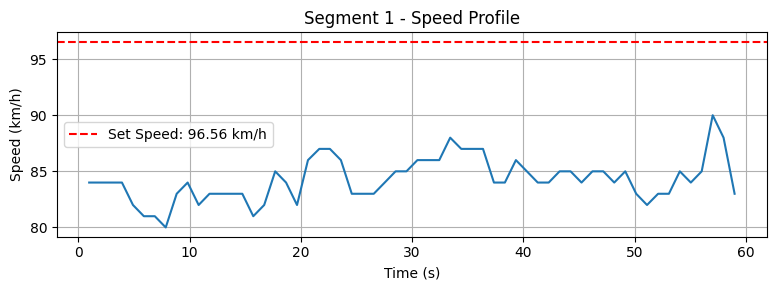

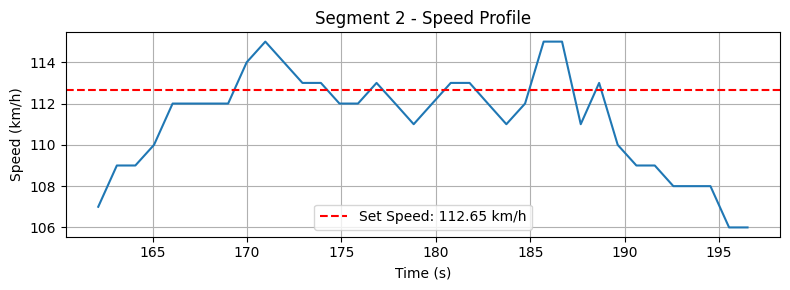

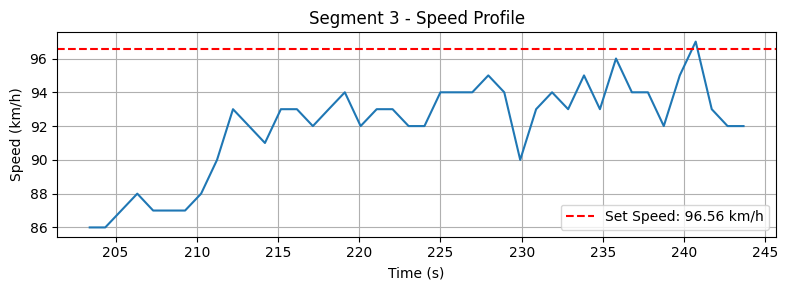

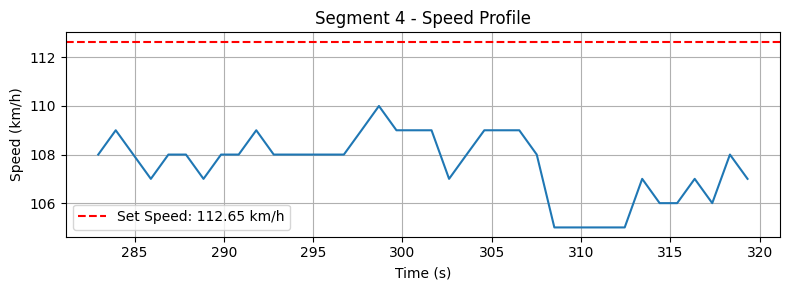

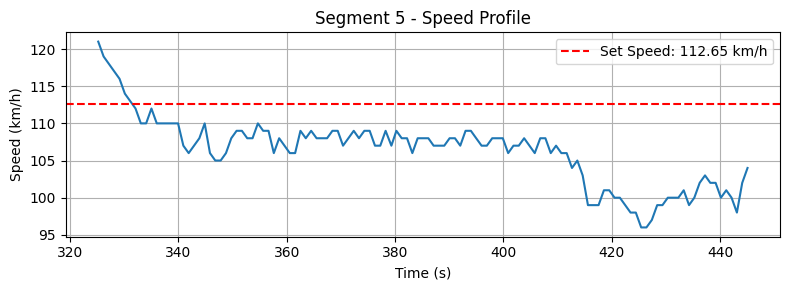

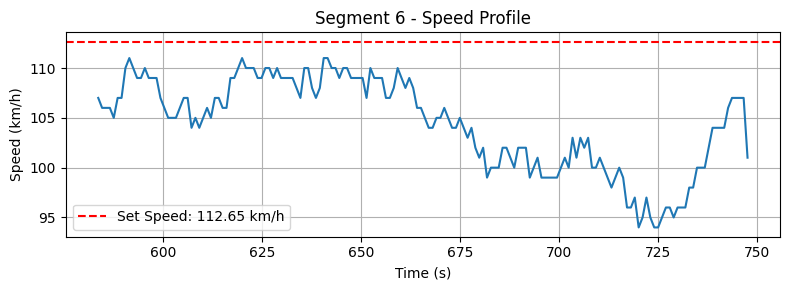

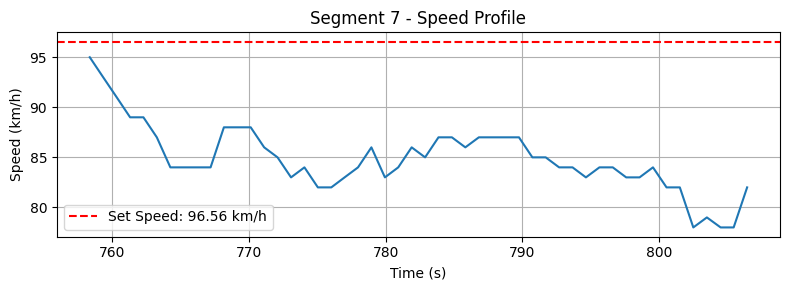

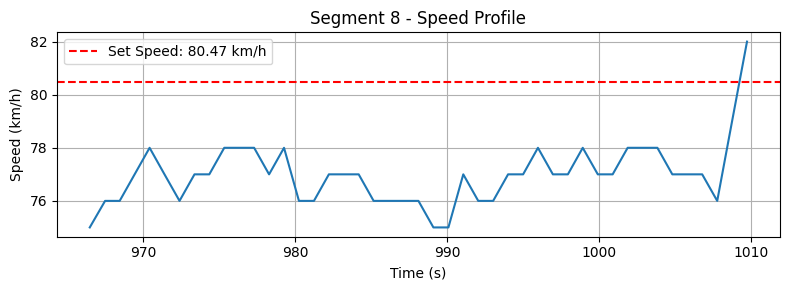

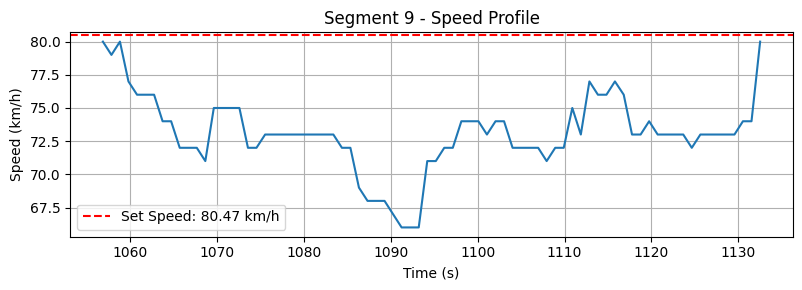

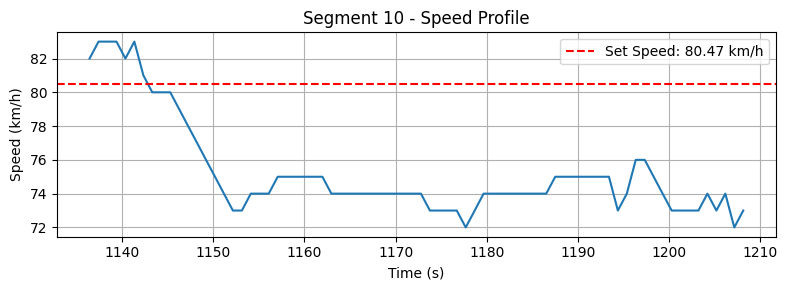

Summary of Speed Controller Accuracy per Stable Segment:


Segment  Start Time (s)  End Time (s)  Duration (s)  Average Speed (km/h)  \
0        1            0.98         59.96         58.01                 84.28   
1        2          162.13        197.49         34.38                111.19   
2        3          203.41        244.64         40.25                 91.98   
3        4          282.96        320.30         36.36                107.58   
4        5          325.21        446.05        119.86                106.30   
5        6          583.57        748.52        163.97                104.38   
6        7          758.34        807.43         48.11                 84.86   
7        8          966.50       1010.69         43.20                 76.98   
8        9         1056.86       1133.50         75.66                 73.09   
9       10         1136.43       1209.12         71.71                 75.24   

   Speed Std Dev (km/h)  Raw Estimate (km/h)  Set Speed Estimate (km/h)  \
0                  1.92                84.28                      96.56   
1                  2.45               111.19                     112.65   
2                  2.81                91.98                      96.56   
3                  1.37               107.58                     112.65   
4                  4.64               106.30                     112.65   
5                  4.63               104.38                     112.65   
6                  3.36                84.86                      96.56   
7                  1.20                76.98                      80.47   
8                  2.84                73.09                      80.47   
9                  2.85                75.24                      80.47   

   Deviation (km/h)  Accuracy (%)  
0          -12.2767       87.2860  
1           -1.4556       98.7079  
2           -4.5838       95.2529  
3           -5.0711       95.4984  
4           -6.3492       94.3638  
5           -8.2690       92.6595  
6          -11.7000       87.8832  
7           -3.4922       95.6602  
8           -7.3803       90.8286  
9           -5.2268       93.5047

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import IPython.display as ipd

def speed_controller_accuracy_per_segment(segments, speed_col='Speed_kmh', time_col='Elapsed_s'):
    """
    Assess speed controller accuracy for each individual stable segment using Random Forest,
    snapping predictions UP to the nearest known set speed (in kph) if within ±20%.

    Parameters:
        segments (list): Output from find_dynamic_stable_speed_segments
        speed_col (str): Speed column name
        time_col (str): Time column name

    Returns:
        pd.DataFrame: Summary table with per-segment performance.
    """
    results = []

    # Define valid target set speeds in kph (converted from mph)
    mph_targets = [30, 40, 50, 60, 70, 80]
    kph_targets = sorted([round(mph * 1.60934, 2) for mph in mph_targets])  # [48.28, 64.37, ..., 128.75]

    def snap_up_to_valid_set_speed(predicted_speed, valid_targets, tolerance=0.2):
        """
        Snap predicted speed UP to the nearest valid set speed if within ±tolerance range.
        """
        for target in valid_targets:
            lower = target * (1 - tolerance)
            upper = target * (1 + tolerance)
            if lower <= predicted_speed <= target:
                return target
        return round(predicted_speed, 2)  # fallback

    for i, (start_time, end_time, seg_df) in enumerate(segments):
        df = seg_df.copy().sort_values(by=time_col).reset_index(drop=True)

        if len(df) < 10:
            continue  # Skip very short segments

        duration = df[time_col].iloc[-1] - df[time_col].iloc[0]
        avg_speed = df[speed_col].mean()
        std_speed = df[speed_col].std()

        # Prepare training data for this single segment (just one row)
        X = pd.DataFrame({
            'Duration (s)': [duration],
            'Speed Std Dev (km/h)': [std_speed]
        })
        y = [avg_speed]

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        predicted_set_speed_raw = rf.predict(X)[0]

        # Snap UP to nearest valid set speed within ±20% range
        predicted_set_speed = snap_up_to_valid_set_speed(predicted_set_speed_raw, kph_targets)

        deviation = avg_speed - predicted_set_speed
        accuracy = 100 - abs(deviation) / predicted_set_speed * 100

        # Store results
        results.append({
            'Segment': i + 1,
            'Start Time (s)': round(start_time, 2),
            'End Time (s)': round(end_time, 2),
            'Duration (s)': round(duration, 2),
            'Average Speed (km/h)': round(avg_speed, 2),
            'Speed Std Dev (km/h)': round(std_speed, 2),
            'Raw Estimate (km/h)': round(predicted_set_speed_raw, 2),
            'Set Speed Estimate (km/h)': predicted_set_speed,
            'Deviation (km/h)': round(deviation, 4),
            'Accuracy (%)': round(accuracy, 4)
        })

        # Plot speed for the segment
        plt.figure(figsize=(8, 3))
        sns.lineplot(data=df, x=time_col, y=speed_col)
        plt.axhline(predicted_set_speed, color='r', linestyle='--',
                    label=f"Set Speed: {predicted_set_speed} km/h")
        plt.title(f"Segment {i+1} - Speed Profile")
        plt.xlabel("Time (s)")
        plt.ylabel("Speed (km/h)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)

# ========================
# Example usage:
# ========================
segments = find_dynamic_stable_speed_segments(
    dataset1,
    rolling_window=5,
    std_threshold=3.0,
    min_duration=30
)

result_df = speed_controller_accuracy_per_segment(segments, speed_col='Speed_kmh', time_col='Elapsed_s')

print("Summary of Speed Controller Accuracy per Stable Segment:")
ipd.display(result_df)